##NOTA: il codice è stato costruito con il vecchio file credit_scoring.csv molto sporco (con duplicati e molti nan)

In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

data = pd.read_csv('./credit_scoring.csv')

In [2]:
def column_summary(df):
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df

summary_df = column_summary(data)
display(summary_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,ID,int64,0,338427,338427,"{5008804: 1, 5979412: 1, 5979410: 1, 5979409: ..."
1,CODE_GENDER,object,0,338427,2,"{'F': 227916, 'M': 110511}"
2,FLAG_OWN_CAR,object,0,338427,2,"{'N': 213196, 'Y': 125231}"
3,FLAG_OWN_REALTY,object,0,338427,2,"{'Y': 231307, 'N': 107120}"
4,CNT_CHILDREN,int64,0,338427,12,"{0: 234631, 1: 67922, 2: 31117, 3: 4252, 4: 36..."
5,AMT_INCOME_TOTAL,float64,0,338427,749,"{135000.0: 36174, 157500.0: 30306, 180000.0: 2..."
6,NAME_INCOME_TYPE,object,0,338427,5,"{'Working': 174366, 'Commercial associate': 78..."
7,NAME_EDUCATION_TYPE,object,0,338427,6,"{'Secondary / secondary special': 232568, 'Hig..."
8,NAME_FAMILY_STATUS,object,1,338426,5,"{'Married': 231494, 'Single / not married': 42..."
9,NAME_HOUSING_TYPE,object,1,338426,6,"{'House / apartment': 304410, 'With parents': ..."


The dataset contains 19 columns with a mix of data types such as integers (int64), floating-point numbers (float64), and objects (usually representing categorical data).

ID columns can be removed since it does not give any info for the model creation.
After ID removal we can also remove the duplicates (same features and same target)

In [3]:
data_no_id = data.drop(columns=['ID'])
duplicates_same_target = data_no_id.duplicated(keep=False)
data_no_duplicates = data_no_id[~duplicates_same_target]
data_no_duplicates

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
76,F,N,Y,0,315000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-20186.0,365243.0,1.0,0.0,0.0,0.0,NaN,1.0,0
209,F,Y,Y,0,270000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19861.0,-10843.0,1.0,0.0,0.0,1.0,Laborers,2.0,1
210,F,Y,Y,0,270000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19861.0,-10843.0,1.0,0.0,0.0,1.0,Laborers,2.0,0
238,F,Y,Y,0,112500.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-7489.0,-797.0,1.0,0.0,1.0,1.0,Private service staff,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338341,F,N,Y,1,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-11598.0,-2694.0,1.0,0.0,0.0,0.0,NaN,3.0,0
338379,M,Y,N,0,450000.0,State servant,Higher education,Married,House / apartment,-18441.0,-2055.0,1.0,0.0,0.0,0.0,Managers,2.0,1
338384,F,N,N,0,103500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-15317.0,-1233.0,1.0,0.0,1.0,0.0,Cooking staff,2.0,0
338416,M,Y,Y,1,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16570.0,-655.0,1.0,0.0,1.0,0.0,Drivers,3.0,0


We should remove also those rows in which there are same features but different target, because these can mislead the model in the training phase

In [4]:
features_only = data_no_id.drop(columns=['TARGET'])
duplicates_diff_target = features_only.duplicated(keep=False)
data_no_duplicates[~duplicates_diff_target]

<ipython-input-4-9cb1c1889ca8>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_no_duplicates[~duplicates_diff_target]


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
76,F,N,Y,0,315000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-20186.0,365243.0,1.0,0.0,0.0,0.0,NaN,1.0,0
238,F,Y,Y,0,112500.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-7489.0,-797.0,1.0,0.0,1.0,1.0,Private service staff,1.0,0
239,F,N,Y,0,94500.0,Pensioner,Higher education,Married,House / apartment,-22331.0,365243.0,1.0,0.0,1.0,0.0,NaN,2.0,0
254,M,N,Y,1,180000.0,Working,Secondary / secondary special,Married,With parents,-14122.0,-1286.0,1.0,0.0,0.0,0.0,Drivers,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338341,F,N,Y,1,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-11598.0,-2694.0,1.0,0.0,0.0,0.0,NaN,3.0,0
338379,M,Y,N,0,450000.0,State servant,Higher education,Married,House / apartment,-18441.0,-2055.0,1.0,0.0,0.0,0.0,Managers,2.0,1
338384,F,N,N,0,103500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-15317.0,-1233.0,1.0,0.0,1.0,0.0,Cooking staff,2.0,0
338416,M,Y,Y,1,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16570.0,-655.0,1.0,0.0,1.0,0.0,Drivers,3.0,0


In [5]:
final_data = data_no_duplicates[~duplicates_diff_target]

final_data.shape, final_data.duplicated().sum()

<ipython-input-5-c97dfb19c49e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_data = data_no_duplicates[~duplicates_diff_target]


((11118, 18), 0)

Let's split the dataset in training and test dataset, but keeping the same target distribution (so that in case of unbalancing we do not risk to train the model on too low minority samples)

In [6]:
X = final_data.drop(["TARGET"], axis=1)
y = final_data["TARGET"].astype(int)

# Split in train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

In [7]:
import numpy as np
import pandas as pd

# Gets additional value such as min / median / max etc.
def column_summary_plus(df):
    # Initialize an empty list to collect rows of summary data
    summary_data = []

    # Loop through each column in the DataFrame
    for column in df.columns:
        print(f"Start processing {column} col with {df[column].dtype} dtype")
        # Get column dtype
        col_dtype = df[column].dtype
        # Get distinct values and their counts
        value_counts = df[column].value_counts()
        distinct_values = value_counts.index.tolist()
        # Get number of distinct values
        num_distinct_values = len(distinct_values)
        # Get min and max values
        sorted_values = sorted(distinct_values)
        min_value = sorted_values[0] if sorted_values else None
        max_value = sorted_values[-1] if sorted_values else None

        # Get median value
        non_distinct_val_list = sorted(df[column].dropna().tolist())
        len_non_distinct_val_list = len(non_distinct_val_list)
        if len_non_distinct_val_list == 0:
            median = None
        else:
            median = non_distinct_val_list[len_non_distinct_val_list // 2]

        # Get average value if the column is numeric
        if np.issubdtype(df[column].dtype, np.number):
            if len(non_distinct_val_list) > 0:
                average = sum(non_distinct_val_list) / len_non_distinct_val_list
                non_zero_val_list = [v for v in non_distinct_val_list if v > 0]
                average_non_zero = sum(non_zero_val_list) / len(non_zero_val_list) if non_zero_val_list else None
            else:
                average = None
                average_non_zero = None
        else:
            average = None
            average_non_zero = None

        # Check if null values are present
        null_present = 1 if df[column].isnull().any() else 0

        # Get number of nulls and non-nulls
        num_nulls = df[column].isnull().sum()
        num_non_nulls = df[column].notnull().sum()

        # Distinct_values only take top 10 distinct values count
        top_10_d_v = value_counts.head(10).index.tolist()
        top_10_c = value_counts.head(10).tolist()
        top_10_d_v_dict = dict(zip(top_10_d_v, top_10_c))

        # Collect the column summary in a dictionary
        column_summary = {
            'col_name': column,
            'col_dtype': col_dtype,
            'num_distinct_values': num_distinct_values,
            'min_value': min_value,
            'max_value': max_value,
            'median_no_na': median,
            'average_no_na': average,
            'average_non_zero': average_non_zero,
            'null_present': null_present,
            'nulls_num': num_nulls,
            'non_nulls_num': num_non_nulls,
            'distinct_values': top_10_d_v_dict
        }
        # Append the summary to the list
        summary_data.append(column_summary)

    # Convert the list of summaries into a DataFrame
    result_df = pd.DataFrame(summary_data)

    return result_df

# Example usage:
# Assuming df is your DataFrame
summary_df = column_summary_plus(data_train)
display(summary_df)

Start processing CODE_GENDER col with object dtype
Start processing FLAG_OWN_CAR col with object dtype
Start processing FLAG_OWN_REALTY col with object dtype
Start processing CNT_CHILDREN col with int64 dtype
Start processing AMT_INCOME_TOTAL col with float64 dtype
Start processing NAME_INCOME_TYPE col with object dtype
Start processing NAME_EDUCATION_TYPE col with object dtype
Start processing NAME_FAMILY_STATUS col with object dtype
Start processing NAME_HOUSING_TYPE col with object dtype
Start processing DAYS_BIRTH col with float64 dtype
Start processing DAYS_EMPLOYED col with float64 dtype
Start processing FLAG_MOBIL col with float64 dtype
Start processing FLAG_WORK_PHONE col with float64 dtype
Start processing FLAG_PHONE col with float64 dtype
Start processing FLAG_EMAIL col with float64 dtype
Start processing OCCUPATION_TYPE col with object dtype
Start processing CNT_FAM_MEMBERS col with float64 dtype
Start processing TARGET col with int64 dtype


,col_name,col_dtype,num_distinct_values,min_value,max_value,median_no_na,average_no_na,average_non_zero,null_present,nulls_num,non_nulls_num,distinct_values
0,CODE_GENDER,object,2,F,M,F,NaN,NaN,0,0,7782,"{'F': 4794, 'M': 2988}"
1,FLAG_OWN_CAR,object,2,N,Y,N,NaN,NaN,0,0,7782,"{'N': 5280, 'Y': 2502}"
2,FLAG_OWN_REALTY,object,2,N,Y,Y,NaN,NaN,0,0,7782,"{'Y': 5258, 'N': 2524}"
3,CNT_CHILDREN,int64,7,0,6,0,0.406836,1.387988,0,0,7782,"{0: 5501, 1: 1513, 2: 669, 3: 87, 4: 7, 5: 4, ..."
4,AMT_INCOME_TOTAL,float64,242,27000.0,1260000.0,135000.0,160386.528180,160386.528180,0,0,7782,"{135000.0: 985, 112500.0: 844, 180000.0: 658, ..."
5,NAME_INCOME_TYPE,object,5,Commercial associate,Working,Working,NaN,NaN,0,0,7782,"{'Working': 4082, 'Commercial associate': 1867..."
6,NAME_EDUCATION_TYPE,object,6,Academic degree,Secondary / secondary special,Secondary / secondary special,NaN,NaN,0,0,7782,"{'Secondary / secondary special': 5706, 'Highe..."
7,NAME_FAMILY_STATUS,object,5,Civil marriage,Widow,Married,NaN,NaN,1,1,7781,"{'Married': 4821, 'Single / not married': 1314..."
8,NAME_HOUSING_TYPE,object,6,Co-op apartment,With parents,House / apartment,NaN,NaN,1,1,7781,"{'House / apartment': 6851, 'With parents': 39..."
9,DAYS_BIRTH,float64,6177,-25159.0,-7489.0,-15287.0,-15630.618687,NaN,1,1,7781,"{-13940.0: 5, -13923.0: 4, -18725.0: 4, -15461..."


#Categorical Columns:

CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY are object types with only two distinct values (e.g., F/M for gender, N/Y for owning a car)

NAME_INCOME_TYPE and NAME_EDUCATION_TYPE have a small number of categories. For example, Working is the most common income type.

#Numeric Columns:

CNT_CHILDREN (number of children) has 7 distinct values, with a minimum of 0 and a maximum of 6. The median number of children is 0, and the average is around 0.4.

AMT_INCOME_TOTAL (income amount) has 242 distinct values, with a range from 27,000 to 1,260,000. The median income is 135,000, while the average income is about 160,386.

DAYS_BIRTH and DAYS_EMPLOYED are date-based columns represented as floating-point numbers, showing negative values (representing days since birth or employment).

#Boolean Columns:

Columns like FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL contain binary data (0 or 1), representing whether the individual has a work phone, phone, or email, respectively. The distinct values and their counts show the prevalence of each attribute.

##Null Values:

Some columns, such as OCCUPATION_TYPE, have many missing values (over 2,392 nulls). This may indicate that this attribute is not provided for many entries, and it could require special handling in the analysis.

##Target Column:

The TARGET column has two distinct values (0 and 1), representing the target label for the classification task, with a distribution showing that most entries have a target value of 0 (7,340 cases), and fewer have a target value of 1 (442 cases).

In [8]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(data_train.describe())
print(data_train.duplicated().sum())

       CNT_CHILDREN  AMT_INCOME_TOTAL    DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE   FLAG_PHONE   FLAG_EMAIL  CNT_FAM_MEMBERS       TARGET
count   7782.000000      7.782000e+03   7781.000000    7781.000000      7781.0      7781.000000  7781.000000  7781.000000      7781.000000  7782.000000
mean       0.406836      1.603865e+05 -15630.618687   63342.902069         1.0         0.205758     0.261535     0.091248         2.128390     0.056798
std        0.710864      8.146778e+04   4458.395318  140570.274657         0.0         0.404280     0.439499     0.287980         0.907746     0.231471
min        0.000000      2.700000e+04 -25159.000000  -16135.000000         1.0         0.000000     0.000000     0.000000         1.000000     0.000000
25%        0.000000      1.125000e+05 -19246.000000   -2390.000000         1.0         0.000000     0.000000     0.000000         2.000000     0.000000
50%        0.000000      1.350000e+05 -15287.000000   -1051.000000         1.0         0

Let's apply preprocessing on some variables both on train and test dataset

In [9]:
# Convert DAYS_BIRTH to AGE (in years) by dividing by -365 and taking the absolute value
data_train['AGE'] = abs(data_train['DAYS_BIRTH'] / 365)

# Convert DAYS_EMPLOYED to years of employment by dividing by 365
data_train['YEARS_EMPLOYED'] = data_train['DAYS_EMPLOYED'] / 365

# Drop the original DAYS_BIRTH and DAYS_EMPLOYED columns
data_train = data_train.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'])

# Same for test dataset
data_test['AGE'] = abs(data_test['DAYS_BIRTH'] / 365)

data_test['YEARS_EMPLOYED'] = data_test['DAYS_EMPLOYED'] / 365

data_test = data_test.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'])


I noticed that many 'OCCUPATION_TYPE' nan values can be associated to 'Pensioner' when NAME_INCOME_TYPE is equal to 'Pensioner' and 'YEARS_EMPLOYED' is equal to 1000.6657534246575.
When NAME_INCOME_TYPE is not equal to 'Pensioner' and 'YEARS_EMPLOYED' is still equal to 1000.6657534246575, we cannot conclude anything and so we can put the label 'Missing'

In [10]:
# Give values to OCCUPATION_TYPE using 'Pensioner' when YEARS_EMPLOYED is equal to 1000.6657534246575
data_train.loc[
    (data_train['NAME_INCOME_TYPE'] == 'Pensioner') & (data_train['YEARS_EMPLOYED'] == 1000.6657534246575),
    'OCCUPATION_TYPE'
] = 'Pensioner'


data_test.loc[
    (data_test['NAME_INCOME_TYPE'] == 'Pensioner') & (data_test['YEARS_EMPLOYED'] == 1000.6657534246575),
    'OCCUPATION_TYPE'
] = 'Pensioner'


In [11]:
data_train.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,TARGET,AGE,YEARS_EMPLOYED
count,7782.000000,7.782000e+03,7781.0,7781.000000,7781.000000,7781.000000,7781.000000,7782.000000,7781.000000,7781.000000
mean,0.406836,1.603865e+05,1.0,0.205758,0.261535,0.091248,2.128390,0.056798,42.823613,173.542197
std,0.710864,8.146778e+04,0.0,0.404280,0.439499,0.287980,0.907746,0.231471,12.214782,385.124040
min,0.000000,2.700000e+04,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,20.517808,-44.205479
25%,0.000000,1.125000e+05,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,32.350685,-6.547945
50%,0.000000,1.350000e+05,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,41.882192,-2.879452
75%,1.000000,2.025000e+05,1.0,0.000000,1.000000,0.000000,3.000000,0.000000,52.728767,-0.715068
max,6.000000,1.260000e+06,1.0,1.000000,1.000000,1.000000,8.000000,1.000000,68.928767,1000.665753


In [12]:
data_train.fillna({'OCCUPATION_TYPE':'Missing'}, inplace=True)
data_test.fillna({'OCCUPATION_TYPE':'Missing'}, inplace=True)

'FLAG_MOBIL' has always the same value, so it is not relevant for the predicton

In [13]:
data_train = data_train.drop(columns=['FLAG_MOBIL'])
data_test = data_test.drop(columns=['FLAG_MOBIL'])

In [14]:
numerical_cols = data_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_cols = data_train.select_dtypes(include=['object']).columns.tolist()

print("Variabili Numeriche:")
print(numerical_cols)

print("\nVariabili Categoriali:")
print(categorical_cols)

Variabili Numeriche:
['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'TARGET', 'AGE', 'YEARS_EMPLOYED']

Variabili Categoriali:
['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']


In [15]:
#drop possible still existing nans
data_train = data_train.dropna()
y_train = y_train.loc[data_train.index]
data_test = data_test.dropna()
y_test = y_test.loc[data_test.index]

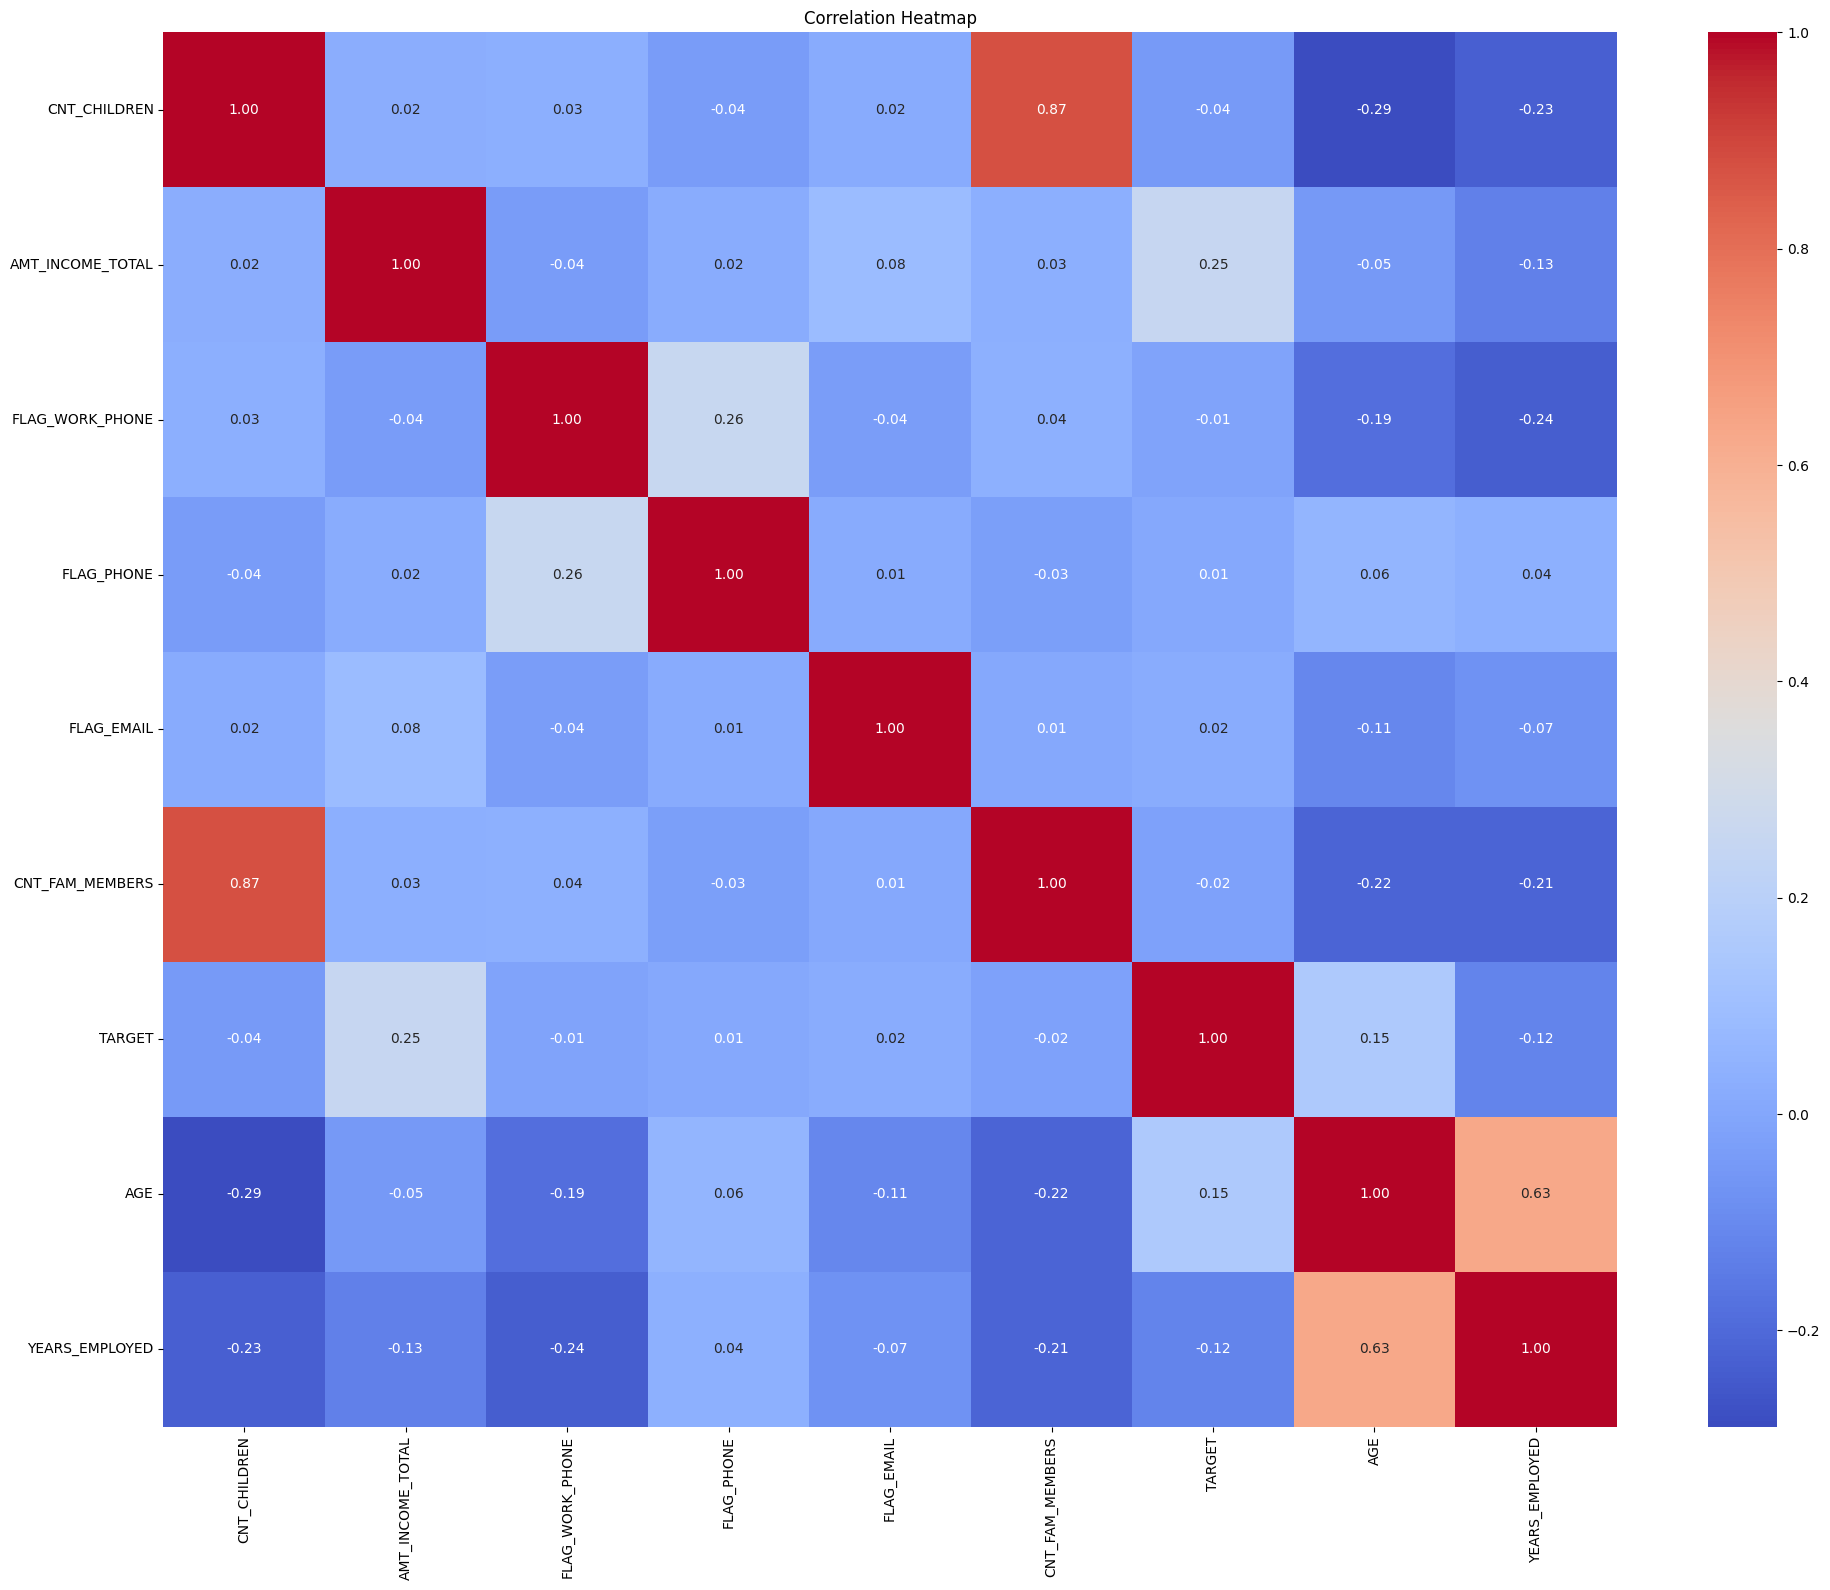

Maximum pairwise correlation: 0.87


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = data_train[numerical_cols].corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()

# Find the max correlation
upper_triangular = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
max_correlation = upper_triangular.max().max()
print(f"Maximum pairwise correlation: {max_correlation:.2f}")

The heatmap and correlation matrix we're analyzing focus on linear correlations between the numerical features of the dataset. This is important to keep in mind, as correlation measures the strength and direction of linear relationships between two variables.

The highest linear correlation is 0.87 between CNT_CHILDREN and CNT_FAM_MEMBERS. This strong correlation suggests that the number of children and the number of family members are closely related, which makes sense since more children likely mean more family members. This could indicate potential feature redundancy, where one of the variables might be dropped or combined in feature engineering.

AMT_INCOME_TOTAL shows a positive linear correlation with the target of 0.25, suggesting that higher income levels are somewhat associated with a higher likelihood of being approved for a credit card.

AGE and YEARS_EMPLOYED have a linear correlation of 0.63, suggesting that older people are associated with larger years of employment, which makes sense.

In [18]:
def iv_woe(data, target, bins=10, show_woe=False):

    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()

    #Extract Column Names
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        #print("Processing variable:", ivars)
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})


        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False,observed=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']

        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

dependent_col = ['TARGET']
all_cols = numerical_cols + categorical_cols + dependent_col
IVDF, woeDF = iv_woe(data_train, 'TARGET', bins=10, show_woe=False)

sorted_IVDF = IVDF.sort_values(by='IV', ascending=False)
display(sorted_IVDF)

,Variable,IV
0,AMT_INCOME_TOTAL,3.822171
0,YEARS_EMPLOYED,3.718966
0,AGE,3.042253
0,OCCUPATION_TYPE,1.190773
0,NAME_INCOME_TYPE,1.074334
0,FLAG_OWN_CAR,0.129045
0,NAME_HOUSING_TYPE,0.107857
0,CNT_FAM_MEMBERS,0.080541
0,NAME_FAMILY_STATUS,0.078407
0,CODE_GENDER,0.064167


Features like AMT_INCOME_TOTAL, YEARS_EMPLOYED, and AGE have IV values around 3 or higher, which are extremely high (but also OCCUPATION_TYPE and NAME_INCOME_TYPE). This means they are very powerful predictors in your dataset but we should have careful review to confirm they reflect genuine predictive power and not data leakage or overfitting

In [19]:
X_train_copy = data_train.drop(columns=['TARGET'])
X_test_copy = data_test.drop(columns=['TARGET'])

In [20]:
X_train_copy[X_train_copy.isna().any(axis=1)]

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED


,TARGET
count,7781.000000
mean,0.056805
std,0.231485
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


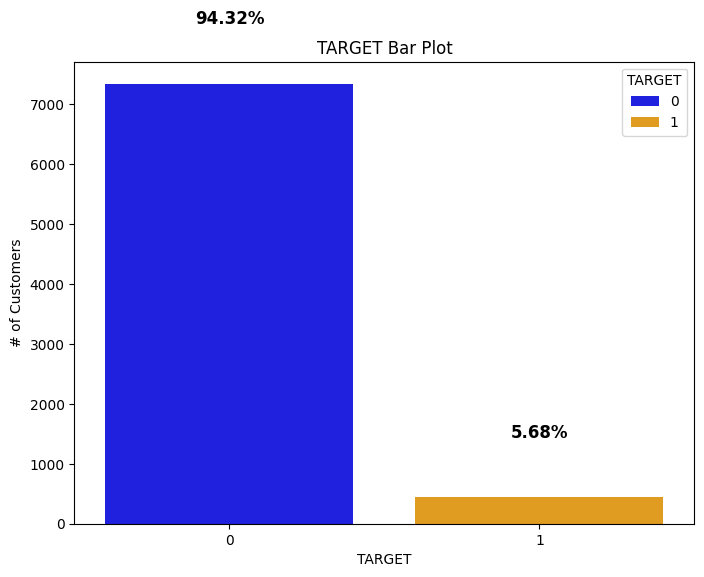

In [21]:
import seaborn as sns

plt.figure(figsize=(8, 6))
ax = sns.countplot(x ='TARGET', data = data_train, hue='TARGET', dodge=False, palette=['blue', 'orange'])
ax.set_title("TARGET Bar Plot")
ax.set_ylabel("# of Customers")
counts = data_train.TARGET.value_counts().values
for i, count in enumerate(counts):
    ax.text(i, count + 1000, f'{count/len(data_train.TARGET)*100:.2f}%', ha='center', fontsize=12, fontweight='bold')

data_train.TARGET.describe()

the TARGET variable is binary with a very low positive rate, meaning that the event of interest (represented by 1) occurs in only about 5.7% of the cases. This imbalance is important to consider when building predictive models

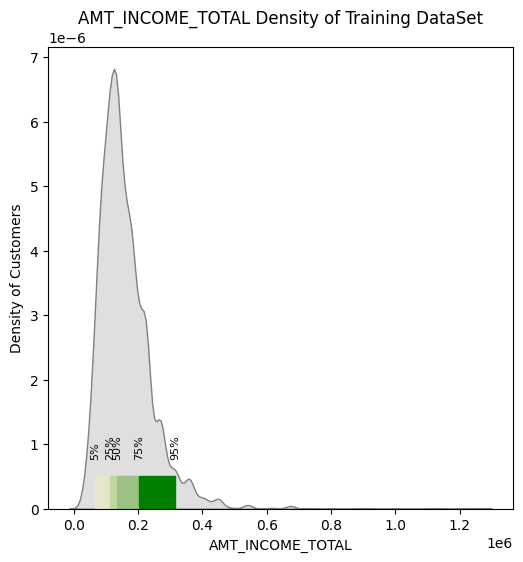

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(X_train_copy['AMT_INCOME_TOTAL'], color='grey', ax=ax, fill=True)

quantiles_to_compute = [5, 25, 50, 75, 95]
quantiles = np.percentile(X_train_copy['AMT_INCOME_TOTAL'], quantiles_to_compute)

colors = ['#E7E5CB', '#C2D6A4', '#9BC184', 'green']
for i in range(len(quantiles) - 1):
    ax.fill_between([quantiles[i], quantiles[i+1]], 0, 0.0000005, color=colors[i])

for i, quantile in enumerate(quantiles):
    ax.text(quantile, 0.0000008, f'{quantiles_to_compute[i]}%', horizontalalignment='center', fontsize=8, rotation=90)

plt.title("AMT_INCOME_TOTAL Density of Training DataSet")
plt.ylabel("Density of Customers")
plt.show()


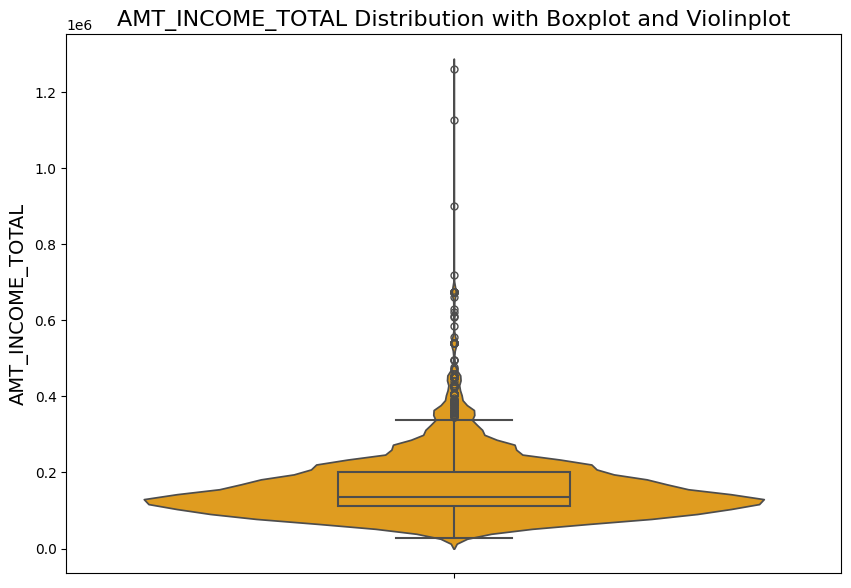

In [23]:
plt.figure(figsize=(10, 7))
sns.violinplot(y='AMT_INCOME_TOTAL', data=X_train_copy, color="orange", inner=None)
sns.boxplot(y='AMT_INCOME_TOTAL', data=X_train_copy, color="orange", fliersize=5, linewidth=1.5, width=0.3)
plt.title('AMT_INCOME_TOTAL Distribution with Boxplot and Violinplot', fontsize=16)
plt.ylabel('AMT_INCOME_TOTAL', fontsize=14)
plt.show()

The income distribution is highly right-skewed, meaning most customers have relatively lower incomes, with a long tail extending toward very high income values. Density Peak: There is a tall peak at lower income ranges, indicating that the bulk of the population falls into a modest income bracket.

The 5th, 25th, 50th (median), and 75th percentiles (as highlighted on the plot) show how the majority of observations lie in the lower income brackets.
A small proportion of customers have significantly higher incomes, which stretches the distribution out to the right.

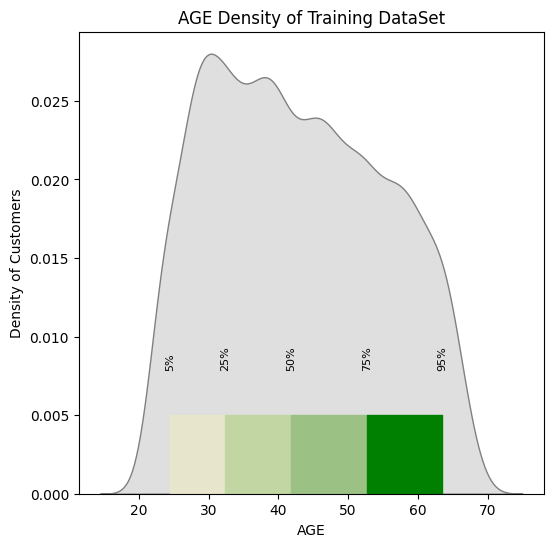

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(X_train_copy['AGE'], color='grey', ax=ax, fill=True)

quantiles_to_compute = [5, 25, 50, 75, 95]
quantiles = np.percentile(X_train_copy['AGE'], quantiles_to_compute)

colors = ['#E7E5CB', '#C2D6A4', '#9BC184', 'green']
for i in range(len(quantiles) - 1):
    ax.fill_between([quantiles[i], quantiles[i+1]], 0, 0.005, color=colors[i])

for i, quantile in enumerate(quantiles):
    ax.text(quantile, 0.008, f'{quantiles_to_compute[i]}%', horizontalalignment='center', fontsize=8, rotation=90)

plt.title("AGE Density of Training DataSet")
plt.ylabel("Density of Customers")
plt.show()


The age distribution appears unimodal (a single peak) and somewhat bell-shaped, although slightly skewed. It spans roughly from the early 20s to the mid/late

The 5th percentile is around the early 20s, indicating that only a small fraction of the dataset is younger than that.
The 25th, 50th (median), and 75th percentiles show a broad spread of ages between about 30 and 50 years.
The 95th percentile is in the mid-to-late 60s, reflecting that relatively few customers are older than this.

In short, the dataset covers a broad adult age range, with a noticeable concentration in the mid-30s to mid-40s.

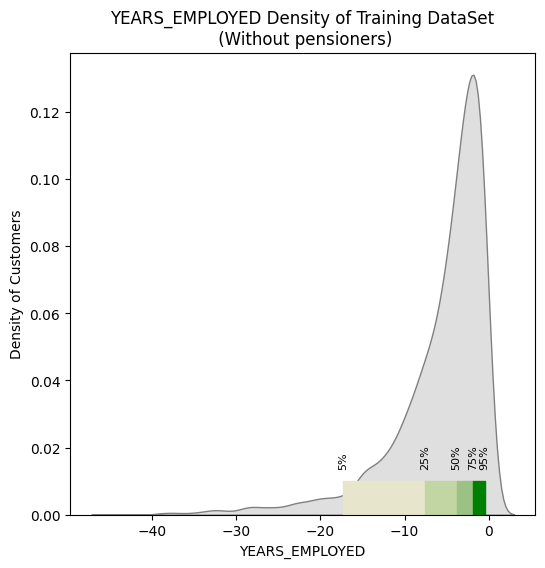

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(X_train_copy['YEARS_EMPLOYED'][X_train_copy['YEARS_EMPLOYED']<1000], color='grey', ax=ax, fill=True)

quantiles_to_compute = [5, 25, 50, 75, 95]
quantiles = np.percentile(X_train_copy['YEARS_EMPLOYED'][X_train_copy['YEARS_EMPLOYED']<1000], quantiles_to_compute)

colors = ['#E7E5CB', '#C2D6A4', '#9BC184', 'green']
for i in range(len(quantiles) - 1):
    ax.fill_between([quantiles[i], quantiles[i+1]], 0, 0.01, color=colors[i])

for i, quantile in enumerate(quantiles):
    ax.text(quantile, 0.014, f'{quantiles_to_compute[i]}%', horizontalalignment='center', fontsize=8, rotation=90)

plt.title("YEARS_EMPLOYED Density of Training DataSet\n (Without pensioners)")
plt.ylabel("Density of Customers")
plt.show()

The distribution shows that among people employed the largest part has been working for few years

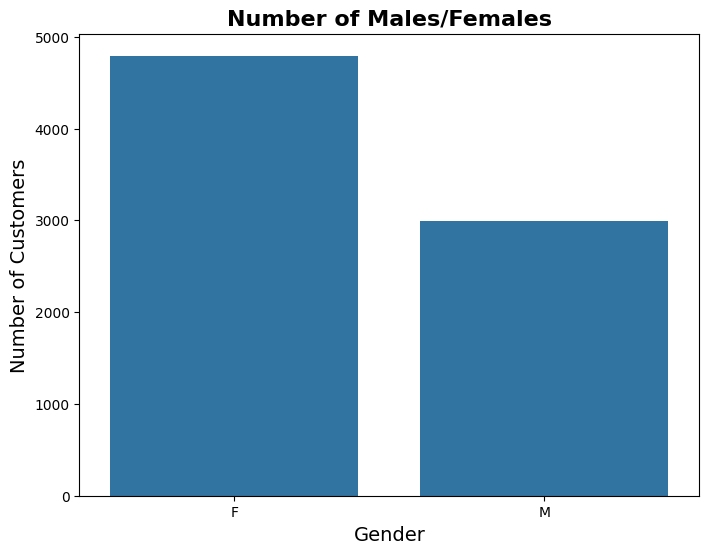

In [26]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='CODE_GENDER', data=data_train)

ax.set_title('Number of Males/Females', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('Gender', fontsize=14)

plt.show()

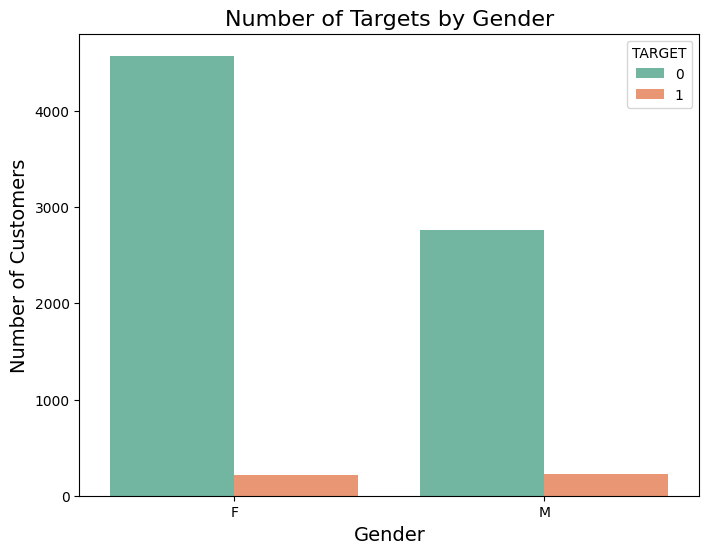

In [27]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='CODE_GENDER', hue='TARGET', data=data_train, palette='Set2')
ax.set_title('Number of Targets by Gender', fontsize=16)
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('Gender', fontsize=14)
plt.show()

In [28]:
count = pd.crosstab(data_train['CODE_GENDER'], data_train['TARGET'], margins=True)
print(count)

TARGET          0    1   All
CODE_GENDER                 
F            4573  220  4793
M            2766  222  2988
All          7339  442  7781


Among females, only about 4.6% are positive, indicating a lower rate of the target event. Among males, the positive rate is higher, at around 7.4%.

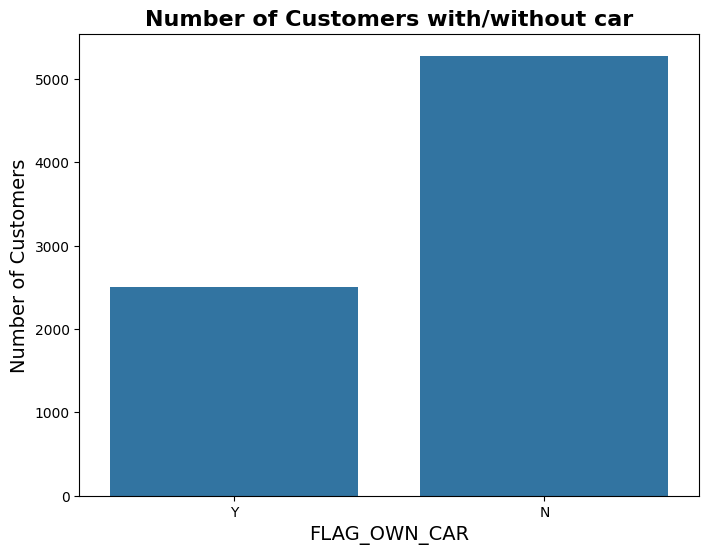

In [29]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='FLAG_OWN_CAR', data=data_train)

ax.set_title('Number of Customers with/without car', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('FLAG_OWN_CAR', fontsize=14)

plt.show()

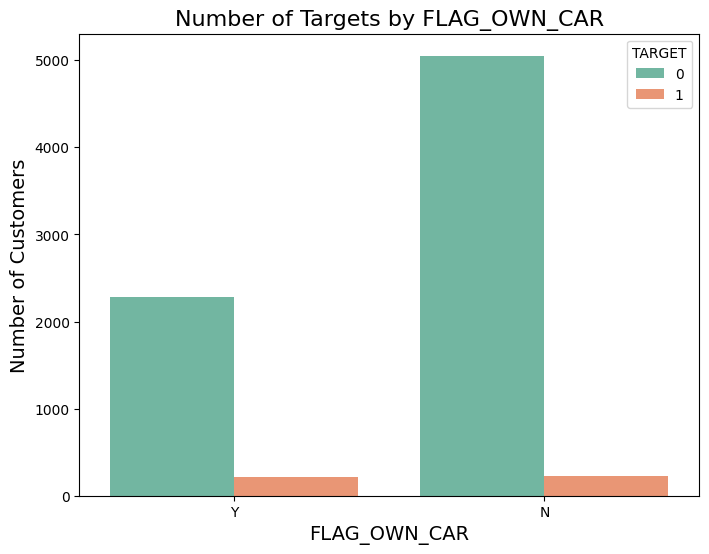

In [30]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='FLAG_OWN_CAR', hue='TARGET', data=data_train, palette='Set2')
ax.set_title('Number of Targets by FLAG_OWN_CAR', fontsize=16)
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('FLAG_OWN_CAR', fontsize=14)
plt.show()

In [31]:
count = pd.crosstab(data_train['FLAG_OWN_CAR'], data_train['TARGET'], margins=True)
print(count)

TARGET           0    1   All
FLAG_OWN_CAR                 
N             5052  227  5279
Y             2287  215  2502
All           7339  442  7781


Customers who own a car are more likely to fall into the TARGET = 1 category compared to those who do not own a car

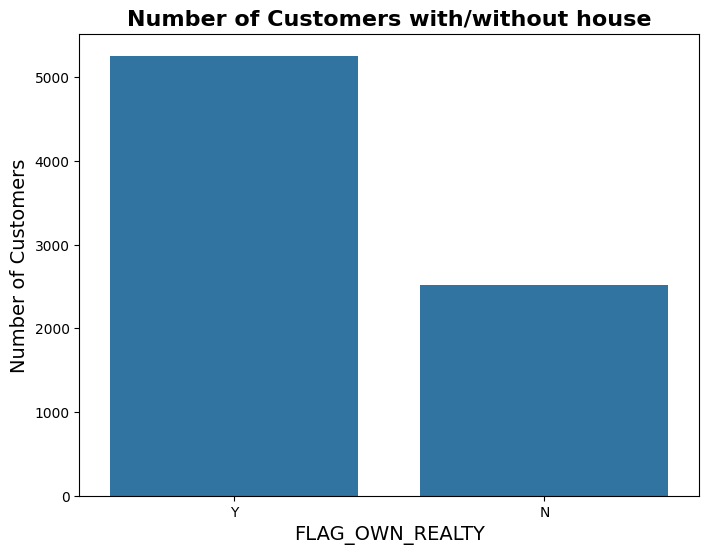

In [32]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='FLAG_OWN_REALTY', data=data_train)

ax.set_title('Number of Customers with/without house', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('FLAG_OWN_REALTY', fontsize=14)

plt.show()

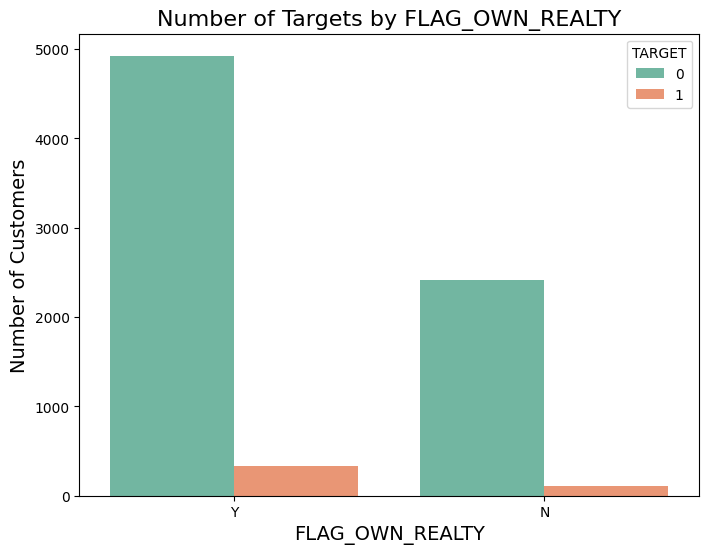

In [33]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='FLAG_OWN_REALTY', hue='TARGET', data=data_train, palette='Set2')
ax.set_title('Number of Targets by FLAG_OWN_REALTY', fontsize=16)
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('FLAG_OWN_REALTY', fontsize=14)
plt.show()

In [34]:
count = pd.crosstab(data_train['FLAG_OWN_REALTY'], data_train['TARGET'], margins=True)
print(count)

TARGET              0    1   All
FLAG_OWN_REALTY                 
N                2413  110  2523
Y                4926  332  5258
All              7339  442  7781


customers who own real estate are more likely to have a positive TARGET compared to those who do not

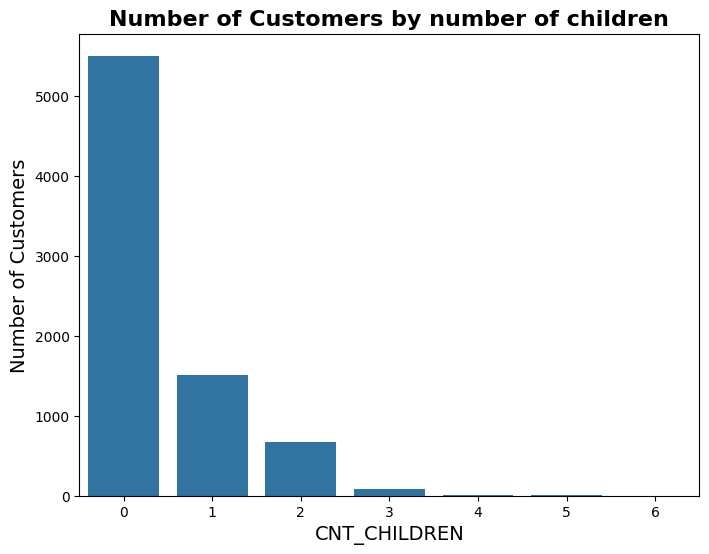

In [35]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='CNT_CHILDREN', data=data_train)

ax.set_title('Number of Customers by number of children', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('CNT_CHILDREN', fontsize=14)

plt.show()

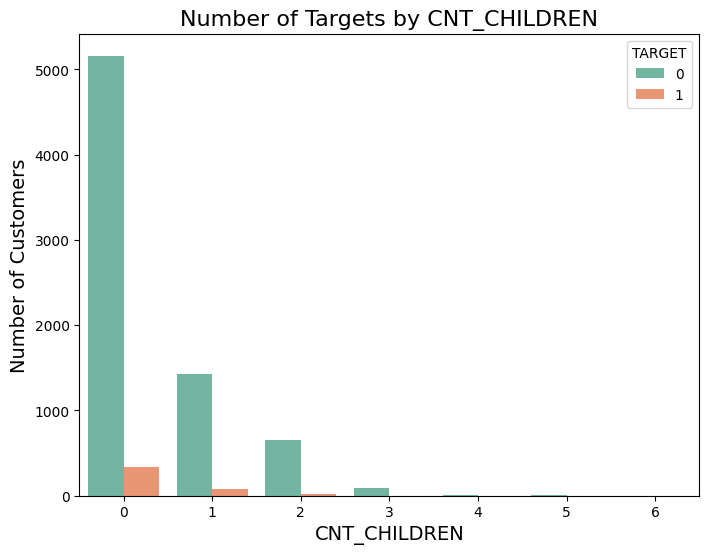

In [36]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='CNT_CHILDREN', hue='TARGET', data=data_train, palette='Set2')
ax.set_title('Number of Targets by CNT_CHILDREN', fontsize=16)
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('CNT_CHILDREN', fontsize=14)
plt.show()

In [37]:
count = pd.crosstab(data_train['CNT_CHILDREN'], data_train['TARGET'], margins=True)
print(count)

TARGET           0    1   All
CNT_CHILDREN                 
0             5161  339  5500
1             1430   83  1513
2              649   20   669
3               87    0    87
4                7    0     7
5                4    0     4
6                1    0     1
All           7339  442  7781


Looking at the crosstable and plot, no conclusions can be done on target from this variable

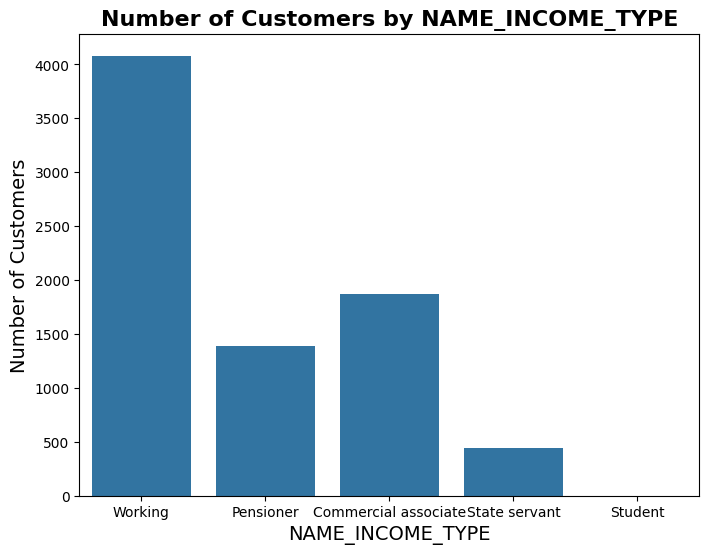

In [38]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='NAME_INCOME_TYPE', data=data_train)

ax.set_title('Number of Customers by NAME_INCOME_TYPE', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('NAME_INCOME_TYPE', fontsize=14)

plt.show()

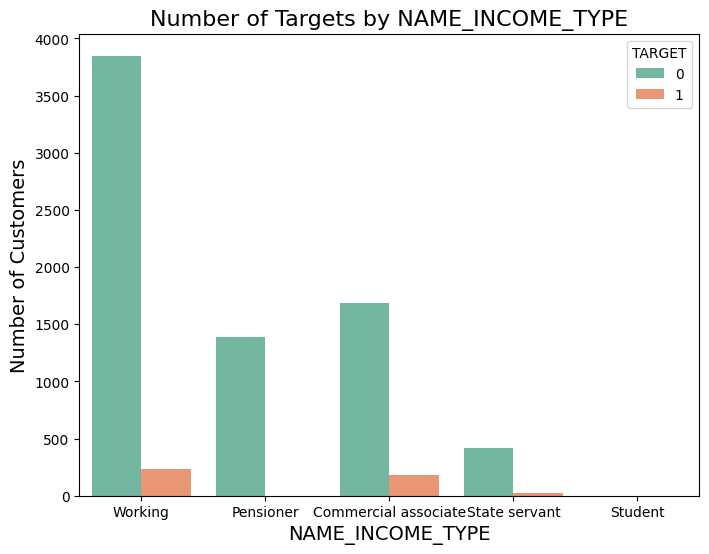

In [39]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='NAME_INCOME_TYPE', hue='TARGET', data=data_train, palette='Set2')
ax.set_title('Number of Targets by NAME_INCOME_TYPE', fontsize=16)
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('NAME_INCOME_TYPE', fontsize=14)
plt.show()

In [40]:
count = pd.crosstab(data_train['NAME_INCOME_TYPE'], data_train['TARGET'], margins=True)
print(count)

TARGET                   0    1   All
NAME_INCOME_TYPE                     
Commercial associate  1683  184  1867
Pensioner             1386    0  1386
State servant          420   26   446
Student                  1    0     1
Working               3849  232  4081
All                   7339  442  7781


##Commercial associate:
This group has the highest rate of the positive TARGET outcome at about 9.9%, which is notably higher than the overall positive rate of 5.7%. This suggests that being a commercial associate might be associated with a higher risk or likelihood of the target event.

##Pensioner and Student:
Neither of these groups has any positive TARGET cases (0%), indicating that, within this dataset, pensioners and students are not represented among those with the positive event. However, be cautious with the student category given its extremely small sample size.

##State servant and Working:
Both these groups have positive rates (approximately 5.8% for state servants and 5.7% for working individuals) that are close to the overall average. This indicates that these income types exhibit the baseline risk level seen in the overall data.

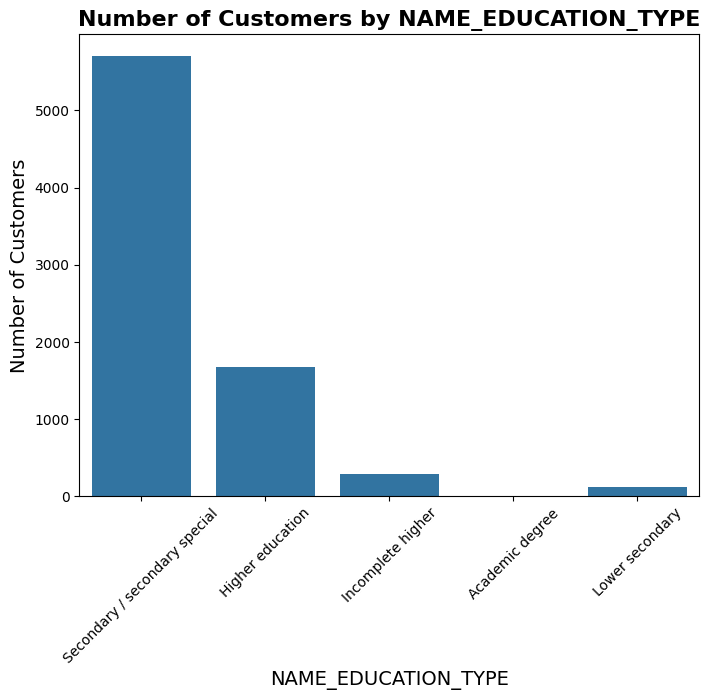

In [41]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='NAME_EDUCATION_TYPE', data=data_train)

ax.set_title('Number of Customers by NAME_EDUCATION_TYPE', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('NAME_EDUCATION_TYPE', fontsize=14)
plt.xticks(rotation=45)

plt.show()

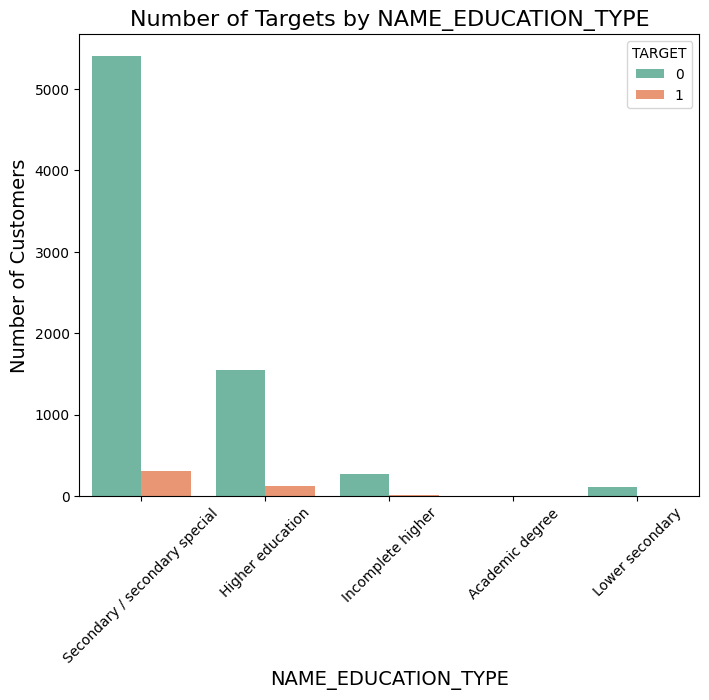

In [42]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='NAME_EDUCATION_TYPE', hue='TARGET', data=data_train, palette='Set2')
ax.set_title('Number of Targets by NAME_EDUCATION_TYPE', fontsize=16)
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('NAME_EDUCATION_TYPE', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [43]:
count = pd.crosstab(data_train['NAME_EDUCATION_TYPE'], data_train['TARGET'], margins=True)
print(count)

TARGET                            0    1   All
NAME_EDUCATION_TYPE                           
Academic degree                   3    0     3
Higher education               1547  125  1672
Incomplete higher               274   12   286
Lower secondary                 111    3   114
Secondary / secondary special  5404  302  5706
All                            7339  442  7781


Individuals with higher education are more likely to experience the target event, with a positive rate of about 7.5%.
Those with incomplete higher or lower secondary education show lower positive rates.

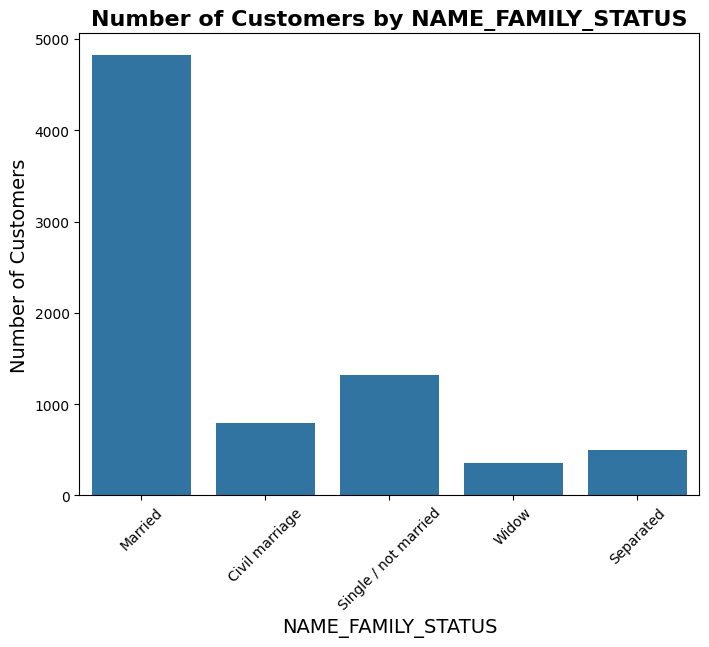

In [44]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='NAME_FAMILY_STATUS', data=data_train)

ax.set_title('Number of Customers by NAME_FAMILY_STATUS', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('NAME_FAMILY_STATUS', fontsize=14)
plt.xticks(rotation=45)

plt.show()

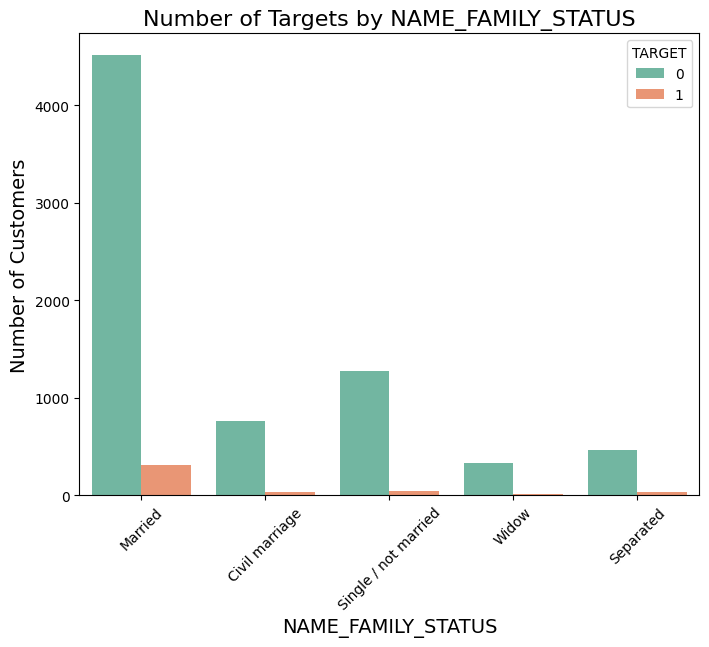

In [45]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='NAME_FAMILY_STATUS', hue='TARGET', data=data_train, palette='Set2')
ax.set_title('Number of Targets by NAME_FAMILY_STATUS', fontsize=16)
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('NAME_FAMILY_STATUS', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [46]:
count = pd.crosstab(data_train['NAME_FAMILY_STATUS'], data_train['TARGET'], margins=True)
print(count)

TARGET                   0    1   All
NAME_FAMILY_STATUS                   
Civil marriage         761   32   793
Married               4511  310  4821
Separated              462   39   501
Single / not married  1272   42  1314
Widow                  333   19   352
All                   7339  442  7781


individuals who are separated or married appear to have a higher incidence of the target event, while those who are single (not married) or in civil marriages show lower incidences

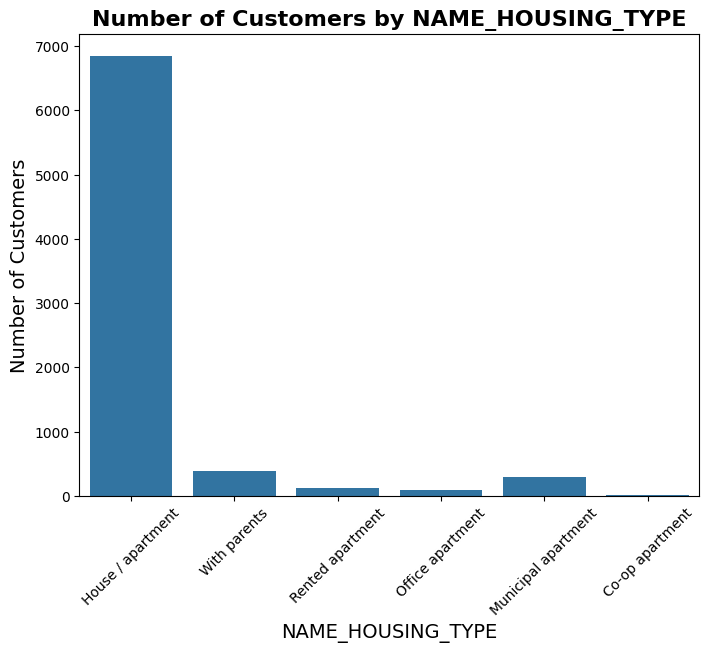

In [47]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='NAME_HOUSING_TYPE', data=data_train)

ax.set_title('Number of Customers by NAME_HOUSING_TYPE', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('NAME_HOUSING_TYPE', fontsize=14)
plt.xticks(rotation=45)

plt.show()

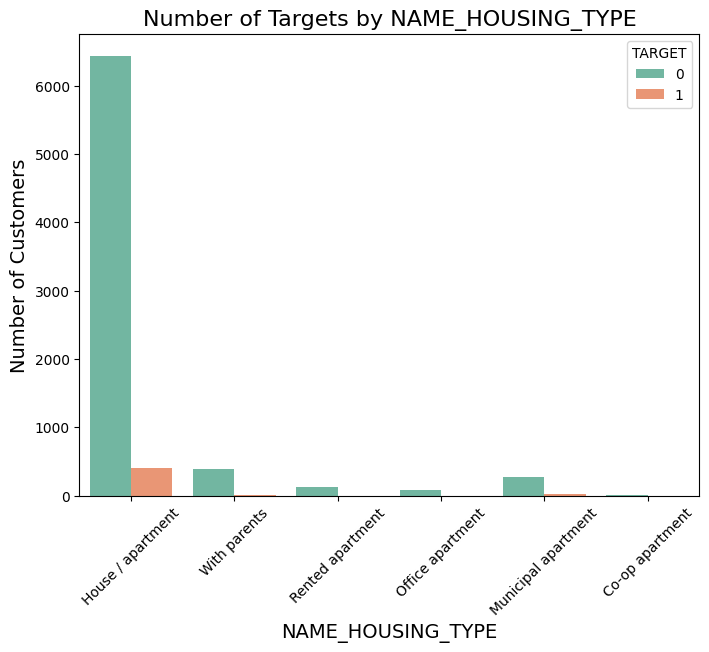

In [48]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='NAME_HOUSING_TYPE', hue='TARGET', data=data_train, palette='Set2')
ax.set_title('Number of Targets by NAME_HOUSING_TYPE', fontsize=16)
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('NAME_HOUSING_TYPE', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [49]:
count = pd.crosstab(data_train['NAME_HOUSING_TYPE'], data_train['TARGET'], margins=True)
print(count)

TARGET                  0    1   All
NAME_HOUSING_TYPE                   
Co-op apartment        16    1    17
House / apartment    6438  413  6851
Municipal apartment   278   20   298
Office apartment       91    2    93
Rented apartment      127    1   128
With parents          389    5   394
All                  7339  442  7781


Customers living in House / apartment and Municipal apartment categories exhibit slightly higher positive rates (6.0% and 6.7%, respectively) compared to the overall average (5.7%).
In contrast, those in Office apartments, Rented apartments, or living with parents show notably lower positive rates (between 0.8% and 2.2%).
However, for categories with very small sample sizes, caution is needed when interpreting the results

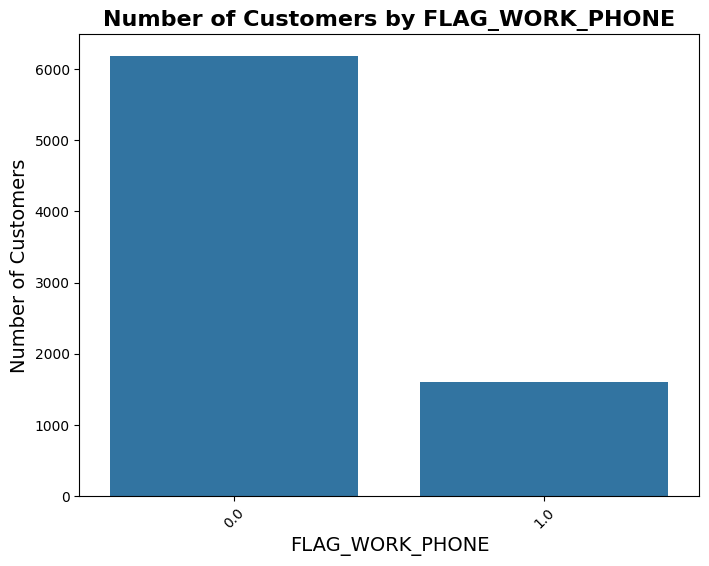

In [50]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='FLAG_WORK_PHONE', data=data_train)

ax.set_title('Number of Customers by FLAG_WORK_PHONE', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('FLAG_WORK_PHONE', fontsize=14)
plt.xticks(rotation=45)

plt.show()

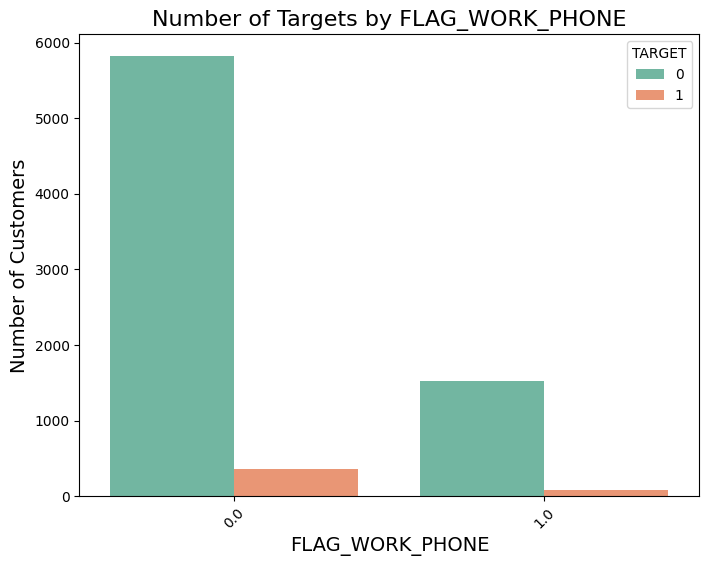

In [51]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='FLAG_WORK_PHONE', hue='TARGET', data=data_train, palette='Set2')
ax.set_title('Number of Targets by FLAG_WORK_PHONE', fontsize=16)
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('FLAG_WORK_PHONE', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [52]:
count = pd.crosstab(data_train['FLAG_WORK_PHONE'], data_train['TARGET'], margins=True)
print(count)

TARGET              0    1   All
FLAG_WORK_PHONE                 
0.0              5819  361  6180
1.0              1520   81  1601
All              7339  442  7781


The TARGET event rate is very similar between the two groups, with a slight increase in the group without a work phone

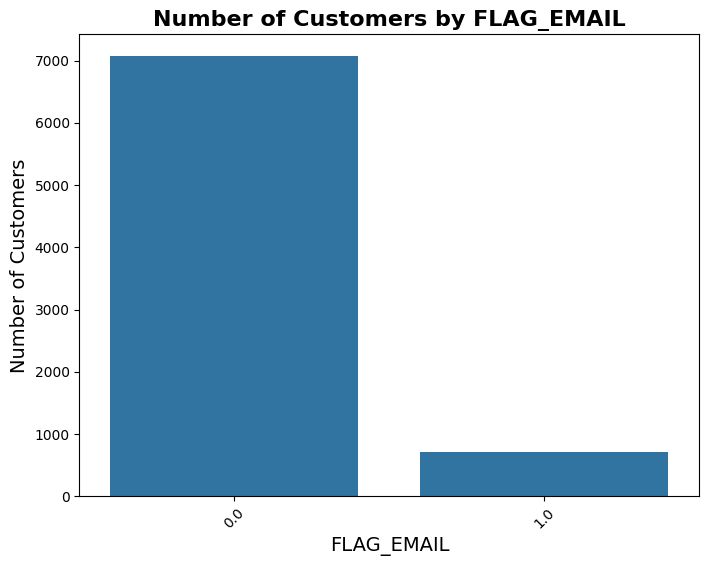

In [53]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='FLAG_EMAIL', data=data_train)

ax.set_title('Number of Customers by FLAG_EMAIL', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('FLAG_EMAIL', fontsize=14)
plt.xticks(rotation=45)

plt.show()

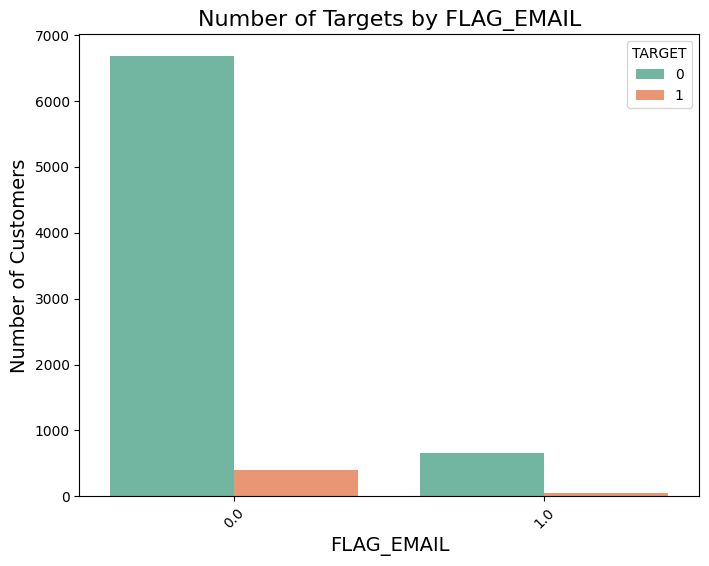

In [54]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='FLAG_EMAIL', hue='TARGET', data=data_train, palette='Set2')
ax.set_title('Number of Targets by FLAG_EMAIL', fontsize=16)
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('FLAG_EMAIL', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [55]:
count = pd.crosstab(data_train['FLAG_EMAIL'], data_train['TARGET'], margins=True)
print(count)

TARGET         0    1   All
FLAG_EMAIL                 
0.0         6679  392  7071
1.0          660   50   710
All         7339  442  7781


The positive rate is slightly higher among customers who have an email compared to those who do not.
Although the difference is modest (7.04% vs. 5.54%), it suggests that email ownership might be associated with a somewhat higher incidence of the target event.
However the group with an email is much smaller (710 observations) than the group without an email (7,071 observations), so this difference might be influenced by the sample size.

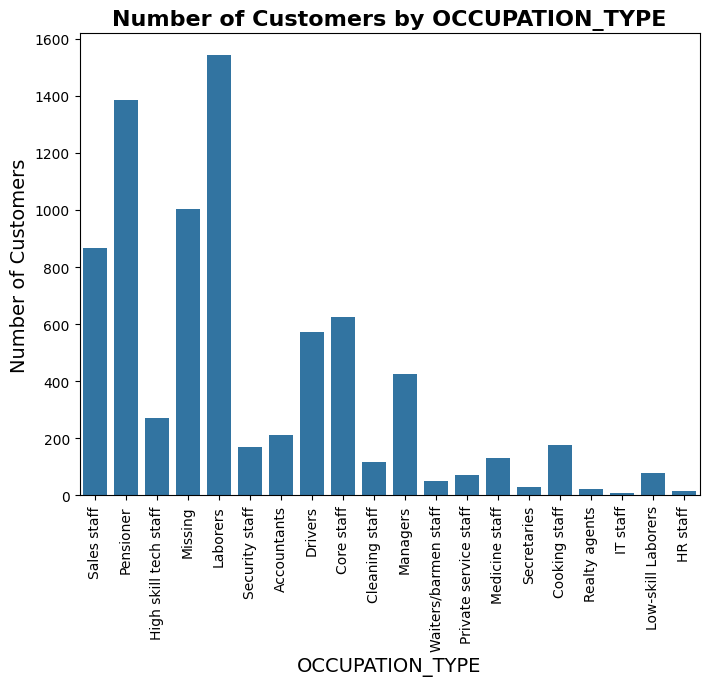

In [56]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='OCCUPATION_TYPE', data=data_train)

ax.set_title('Number of Customers by OCCUPATION_TYPE', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('OCCUPATION_TYPE', fontsize=14)
plt.xticks(rotation=90)

plt.show()

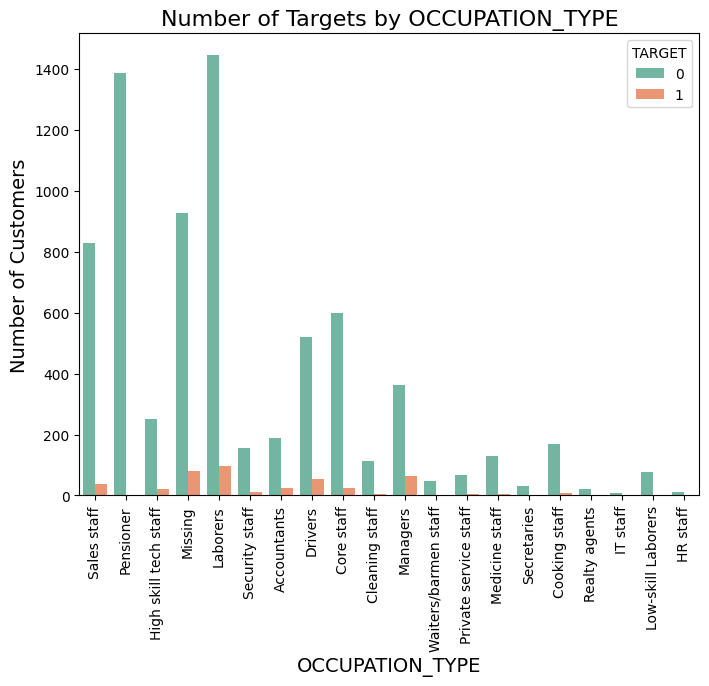

In [57]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='OCCUPATION_TYPE', hue='TARGET', data=data_train, palette='Set2')
ax.set_title('Number of Targets by OCCUPATION_TYPE', fontsize=16)
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('OCCUPATION_TYPE', fontsize=14)
plt.xticks(rotation=90)
plt.show()

In [58]:
count = pd.crosstab(data_train['OCCUPATION_TYPE'], data_train['TARGET'], margins=True)
print(count)

TARGET                    0    1   All
OCCUPATION_TYPE                       
Accountants             190   23   213
Cleaning staff          113    5   118
Cooking staff           169    9   178
Core staff              600   24   624
Drivers                 519   55   574
HR staff                 13    1    14
High skill tech staff   252   20   272
IT staff                  7    1     8
Laborers               1444   98  1542
Low-skill Laborers       78    1    79
Managers                361   65   426
Medicine staff          128    5   133
Missing                 926   79  1005
Pensioner              1386    0  1386
Private service staff    66    4    70
Realty agents            22    0    22
Sales staff             829   38   867
Secretaries              30    0    30
Security staff          157   13   170
Waiters/barmen staff     49    1    50
All                    7339  442  7781


Certain occupations, particularly Managers, Accountants, Drivers, and IT staff (with caution due to small sample size), have a higher incidence of the target event.

Occupations with 0% positive rates are Pensioners, Realty agents and Secretaries).

The variation in the TARGET rates across occupations indicates that OCCUPATION_TYPE is an important variable for the model and should be considered.

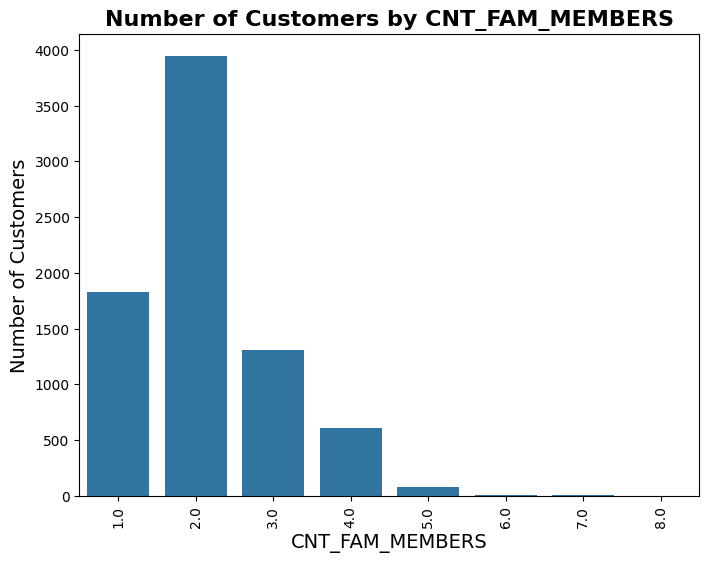

In [59]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='CNT_FAM_MEMBERS', data=data_train)

ax.set_title('Number of Customers by CNT_FAM_MEMBERS', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('CNT_FAM_MEMBERS', fontsize=14)
plt.xticks(rotation=90)

plt.show()

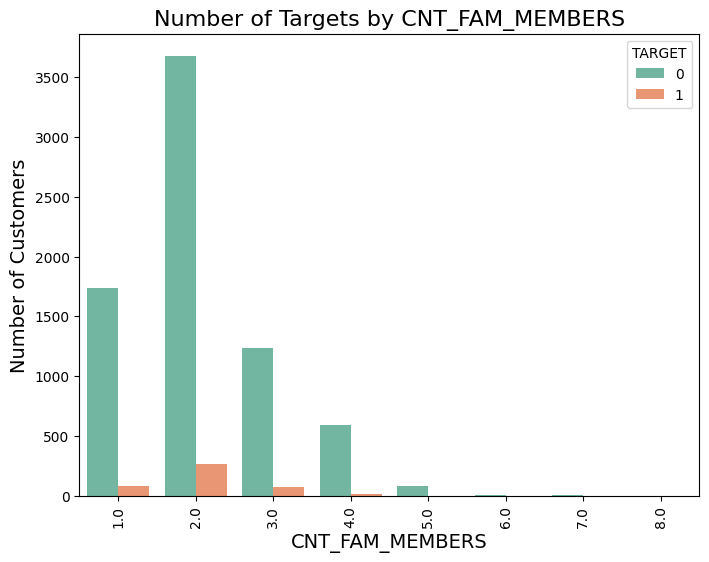

In [60]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='CNT_FAM_MEMBERS', hue='TARGET', data=data_train, palette='Set2')
ax.set_title('Number of Targets by CNT_FAM_MEMBERS', fontsize=16)
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xlabel('CNT_FAM_MEMBERS', fontsize=14)
plt.xticks(rotation=90)
plt.show()

In [61]:
count = pd.crosstab(data_train['CNT_FAM_MEMBERS'], data_train['TARGET'], margins=True)
print(count)

TARGET              0    1   All
CNT_FAM_MEMBERS                 
1.0              1738   85  1823
2.0              3680  267  3947
3.0              1239   72  1311
4.0               589   18   607
5.0                81    0    81
6.0                 7    0     7
7.0                 4    0     4
8.0                 1    0     1
All              7339  442  7781


Households with 2 members have the highest positive rate (6.77%), suggesting that this family structure might be associated with a positive TARGET.
Single-person households (1 family member) and households with 3 members have a positive rate near or below the overall average.
Households with 4 members show a notably lower risk, though this trend might be less reliable for larger households due to the very limited number of observations.

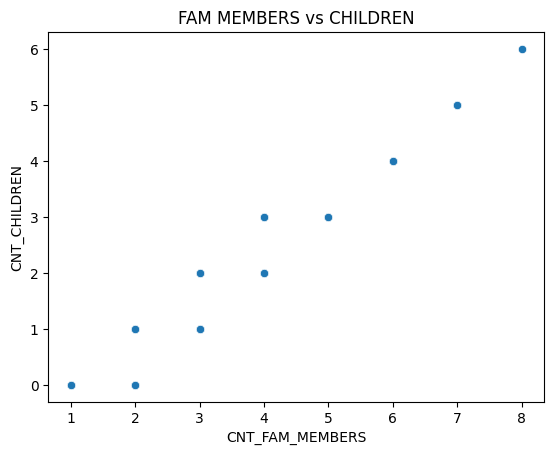

In [62]:
sns.scatterplot(x=X_train['CNT_FAM_MEMBERS'], y=X_train['CNT_CHILDREN'])
plt.title("FAM MEMBERS vs CHILDREN")
plt.show()

Since CNT_CHILDREN and CNT_FAM_MEMBERS are highy correlated and provide more or less same information for TARGET prediction, we can remove CNT_FAM_MEMBERS from the features to be ingested for the model training and prediction.

In [63]:
X_train_copy = data_train.drop(columns=['CNT_FAM_MEMBERS','TARGET'])
X_test_copy = data_test.drop(columns=['CNT_FAM_MEMBERS','TARGET'])

Since we have very few data about 'CNT_CHILDREN' larger than three, we can collect these data in a personalized category called 'Other', so that the number of one-hot-encoded features is kept as low as possible

In [64]:
cnt_children_freq = X_train_copy['CNT_CHILDREN'].value_counts(normalize=True)
rare_cnt_children = cnt_children_freq[cnt_children_freq < 0.01].index
X_train_copy['CNT_CHILDREN'] = X_train_copy['CNT_CHILDREN'].replace(rare_cnt_children, 'Other').astype(str)
cnt_children_freq = X_test_copy['CNT_CHILDREN'].value_counts(normalize=True)
rare_cnt_children = cnt_children_freq[cnt_children_freq < 0.01].index
X_test_copy['CNT_CHILDREN'] = X_test_copy['CNT_CHILDREN'].replace(rare_cnt_children, 'Other').astype(str)

In [65]:
numerical_cols = ['AMT_INCOME_TOTAL', 'AGE', 'YEARS_EMPLOYED']
label_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
hot_cols = ['NAME_INCOME_TYPE',	'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE','CNT_CHILDREN']
other_cols = ['FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']
independent_col=X_train_copy.columns.to_list()

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Apply Label Encoding on categorical binary variables
label_encoders = {}
for col in label_cols:
    le = LabelEncoder()
    X_train_copy[col] = le.fit_transform(X_train_copy[col])
    X_test_copy[col] = le.transform(X_test_copy[col])
    label_encoders[col] = le

# One-Hot Encoder on multiple categorical variables
one_hot_encoder_pipeline = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocessor with numerical, labeled and one-hot encoded variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),                # Standard scaling for numerical variables
        ('onehot', one_hot_encoder_pipeline, hot_cols)            # One-Hot encoding for multi-categorical variables
    ],
    remainder='passthrough'
)

# Apply preprocessing on train and test dataset
X_train_transformed = preprocessor.fit_transform(X_train_copy)
X_test_transformed = preprocessor.transform(X_test_copy)

# Now that we fit the preprocessor we can access named_transformers_
# Ottieni i nomi delle feature dalle variabili numeriche e categoriali (One-Hot)
one_hot_feature_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(hot_cols)
all_feature_names = numerical_cols + list(one_hot_feature_names) + label_cols + other_cols

# Convert in DataFrame with the names of the columns
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)

# Target exctraction (y)
y_train_transformed = y_train.values.ravel()
y_test_transformed = y_test.values.ravel()

print(X_train_transformed_df.head())

   AMT_INCOME_TOTAL       AGE  YEARS_EMPLOYED  NAME_INCOME_TYPE_Commercial associate  NAME_INCOME_TYPE_Pensioner  NAME_INCOME_TYPE_State servant  NAME_INCOME_TYPE_Student  NAME_INCOME_TYPE_Working  NAME_EDUCATION_TYPE_Academic degree  NAME_EDUCATION_TYPE_Higher education  NAME_EDUCATION_TYPE_Incomplete higher  NAME_EDUCATION_TYPE_Lower secondary  NAME_EDUCATION_TYPE_Secondary / secondary special  NAME_FAMILY_STATUS_Civil marriage  NAME_FAMILY_STATUS_Married  NAME_FAMILY_STATUS_Separated  NAME_FAMILY_STATUS_Single / not married  NAME_FAMILY_STATUS_Widow  NAME_HOUSING_TYPE_Co-op apartment  NAME_HOUSING_TYPE_House / apartment  NAME_HOUSING_TYPE_Municipal apartment  NAME_HOUSING_TYPE_Office apartment  NAME_HOUSING_TYPE_Rented apartment  NAME_HOUSING_TYPE_With parents  OCCUPATION_TYPE_Accountants  OCCUPATION_TYPE_Cleaning staff  OCCUPATION_TYPE_Cooking staff  OCCUPATION_TYPE_Core staff  OCCUPATION_TYPE_Drivers  OCCUPATION_TYPE_HR staff  OCCUPATION_TYPE_High skill tech staff  \
0         -0.

In [66]:
# Function for getting feature importance sorted.
def feature_importance_sorted(classification_model_input, X_train, y_train, feature_importance_input=None):
    if classification_model_input is not None:
        some_model = classification_model_input
        some_model.fit(X_train, y_train)
        feature_importances = some_model.feature_importances_
    else:
        feature_importances = feature_importance_input
    feature_importances_sorted = sorted(zip(X_train.columns, feature_importances), key=lambda x: x[1], reverse=True)
    df_feature_importances = pd.DataFrame(feature_importances_sorted, columns=['Feature', 'Importance'])
    for feature_name, importance in feature_importances_sorted:
        print(f"Feature {feature_name}: {importance}")

    df_feature_importances['rank'] = range(1, len(df_feature_importances)+1)
    return df_feature_importances

# Decision Tree Classifier Feature Importance
from sklearn.tree import DecisionTreeClassifier
dtc_fi = feature_importance_sorted(DecisionTreeClassifier(), X_train_transformed_df, y_train)

# Random Forest Classifier Feature Importance
from sklearn.ensemble import RandomForestClassifier
rfc_fi = feature_importance_sorted(RandomForestClassifier(), X_train_transformed_df, y_train.values.ravel())

# XGB Feature Importance
import xgboost as xgb
xgb_fi = feature_importance_sorted(xgb.XGBClassifier(), X_train_transformed_df, y_train)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_transformed_df, y_train.values.ravel())
feature_importances = lr.coef_[0]  # Assuming binary classification
lr_fi = feature_importance_sorted(None, X_train_transformed_df, y_train.values.ravel(), feature_importances)

Feature AGE: 0.46141374727981155
Feature YEARS_EMPLOYED: 0.26435769053978403
Feature AMT_INCOME_TOTAL: 0.12963948335017123
Feature NAME_INCOME_TYPE_Working: 0.012203719041295026
Feature FLAG_PHONE: 0.008422525753055398
Feature FLAG_EMAIL: 0.008176918687718325
Feature FLAG_OWN_REALTY: 0.00767584571116067
Feature NAME_FAMILY_STATUS_Single / not married: 0.007401824081350818
Feature OCCUPATION_TYPE_Managers: 0.006699154258011703
Feature NAME_FAMILY_STATUS_Married: 0.006425094066261722
Feature OCCUPATION_TYPE_Missing: 0.005942197574056248
Feature CNT_CHILDREN_1: 0.005456004167394813
Feature CNT_CHILDREN_2: 0.005293692030289298
Feature OCCUPATION_TYPE_Laborers: 0.005251973321614358
Feature NAME_HOUSING_TYPE_Municipal apartment: 0.005149362324147781
Feature OCCUPATION_TYPE_Sales staff: 0.0050835690385276425
Feature OCCUPATION_TYPE_Core staff: 0.004441618058167959
Feature NAME_EDUCATION_TYPE_Higher education: 0.0038133585547248314
Feature CODE_GENDER: 0.0037102502838964524
Feature NAME_HOUSIN

In [67]:
dtc_fi = dtc_fi.rename(columns={'Importance': 'imp_dtc', 'rank': 'rank_dtc'})
rfc_fi = rfc_fi.rename(columns={'Importance': 'imp_rfc', 'rank': 'rank_rfc'})
xgb_fi = xgb_fi.rename(columns={'Importance': 'imp_xgb', 'rank': 'rank_xgb'})
lr_fi = lr_fi.rename(columns={'Importance': 'imp_lr', 'rank': 'rank_lr'})

merged_df = dtc_fi.merge(rfc_fi, on='Feature', how='left')\
                  .merge(xgb_fi, on='Feature', how='left')\
                  .merge(lr_fi, on='Feature', how='left')

merged_df

,Feature,imp_dtc,rank_dtc,imp_rfc,rank_rfc,imp_xgb,rank_xgb,imp_lr,rank_lr
0,AGE,0.461414,1,0.237679,2,0.116947,2,1.873891,1
1,YEARS_EMPLOYED,0.264358,2,0.241389,1,0.097540,3,-4.314139,55
2,AMT_INCOME_TOTAL,0.129639,3,0.236723,3,0.138592,1,0.758529,2
3,NAME_INCOME_TYPE_Working,0.012204,4,0.009993,13,0.012771,27,-0.197775,41
4,FLAG_PHONE,0.008423,5,0.013605,5,0.024435,10,-0.080803,35
5,FLAG_EMAIL,0.008177,6,0.009663,16,0.022938,12,0.220474,12
6,FLAG_OWN_REALTY,0.007676,7,0.012513,7,0.020725,14,0.089713,24
7,NAME_FAMILY_STATUS_Single / not married,0.007402,8,0.006499,23,0.011810,31,-0.157675,40
8,OCCUPATION_TYPE_Managers,0.006699,9,0.011130,10,0.018954,19,0.191678,16
9,NAME_FAMILY_STATUS_Married,0.006425,10,0.009693,15,0.014147,26,0.060426,27


AGE is consistently the top predictor.
It ranks #1 in the Decision Tree, Random Forest, and Logistic Regression models, and #2 in XGBoost.
This indicates that age is a robust and critical feature across both tree‐based models and linear models.

AMT_INCOME_TOTAL also consistently appears among the top predictors.
It is ranked #3 by Decision Tree and Random Forest, #1 by XGBoost, and #2 by Logistic Regression.
This consistency across models reinforces its importance in distinguishing between the target classes.

YEARS_EMPLOYED shows an interesting pattern:
It is ranked very high by the tree‐based models (ranked #2 by Decision Tree and Random Forest, and #3 by XGBoost) indicating that, in non‐linear splits, it is highly informative.
However, in Logistic Regression it is ranked much lower (rank #55) and has a negative coefficient, suggesting that its linear relationship with the target is different from its role in non‐linear models. Ths can be due to the value associated to Pensioner that is not correctly captured by the simple Logistic Regressor.

OTHER FEATURES:
Features like NAME_INCOME_TYPE_Working, OCCUPATION_TYPE_Managers, and FLAG_OWN_CAR have moderate importance across models but their rankings vary. For example, “NAME_INCOME_TYPE_Working” is ranked #4 by the Decision Tree but much lower by Logistic Regression.
Such differences highlight that tree‐based models (which capture non‐linear interactions) and logistic regression (which relies on a linear combination) may weigh features differently.

##Robust Predictors:
Age and income are universally important in predicting the target outcome. They consistently appear at the top of the rankings regardless of the model.
##Model Differences:
Tree‐based models (Decision Tree, Random Forest, XGBoost) agree closely on the relative importance of features like YEARS_EMPLOYED, suggesting they capture valuable non‐linear patterns.
Logistic Regression’s lower ranking (and negative coefficient) for YEARS_EMPLOYED points to a different, possibly linear, relationship that might not fully capture the complexity of the data

In [68]:
X_train_transformed_df

,AMT_INCOME_TOTAL,AGE,YEARS_EMPLOYED,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Missing,OCCUPATION_TYPE_Pensioner,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,CNT_CHILDREN_0,CNT_CHILDREN_1,CNT_CHILDREN_2,CNT_CHILDREN_3,CNT_CHILDREN_Other,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL
0,-0.587993,-1.184497,-0.455388,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,-0.311787,-1.266371,-0.451454,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,-1.085163,1.642037,2.147819,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
3,0.516831,1.222577,2.147819,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,-0.587993,-1.202218,-0.451560,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7776,0.218528,0.057060,-0.470826,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
7777,-0.864199,-0.588953,-0.479925,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
7778,-0.587993,-1.013124,-0.454684,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7779,-1.085163,1.826645,2.147819,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [69]:
y_train_df=pd.DataFrame(y_train_transformed, columns=['TARGET'])

In [70]:
aff_df = X_train_transformed_df[y_train_df['TARGET']==1]
norm_df = X_train_transformed_df[y_train_df['TARGET']==0]

from scipy.stats import ttest_ind
def individual_t_test(df_1, df_2, listoffeatures, alpha_val):
    '''
    For continuous variable individual t-tests
    '''
    newlist = []
    for feature in listoffeatures:
        fea_1 = df_1[feature]
        fea_2 = df_2[feature]

        t_stat, p_val = ttest_ind(fea_1, fea_2, equal_var=False)
        t_stat1 = f'{t_stat:.3f}'
        p_val1 = f'{p_val:.3f}'

        if p_val < alpha_val:
            sig = 'Significant'
        else:
            sig = 'Insignificant'

        newdict = {'feature': feature, 't_stat': t_stat1,
                   'p_value': p_val1, 'significance': sig}
        newlist.append(newdict)

    df_result = pd.DataFrame(newlist)
    return df_result

individual_t_test(aff_df, norm_df, numerical_cols, 0.05)

,feature,t_stat,p_value,significance
0,AMT_INCOME_TOTAL,21.550,0.000,Significant
1,AGE,27.820,0.000,Significant
2,YEARS_EMPLOYED,-42.573,0.000,Significant


So let's try a simple logistic regressor to fit the data and test

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve

lr = LogisticRegression()
lr.fit(X_train_transformed, y_train_transformed)

y_pred_train = lr.predict(X_train_transformed)
y_proba_train = lr.predict_proba(X_train_transformed)
y_pred_test = lr.predict(X_test_transformed)
y_proba_test =  lr.predict_proba(X_test_transformed)

print("TRAIN REPORT")
print(classification_report(y_train_transformed, y_pred_train))
print("TEST REPORT")
print(classification_report(y_test_transformed, y_pred_test))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7339
           1       0.47      0.14      0.22       442

    accuracy                           0.94      7781
   macro avg       0.71      0.57      0.60      7781
weighted avg       0.92      0.94      0.93      7781

TEST REPORT
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3146
           1       0.40      0.11      0.17       190

    accuracy                           0.94      3336
   macro avg       0.67      0.55      0.57      3336
weighted avg       0.92      0.94      0.92      3336



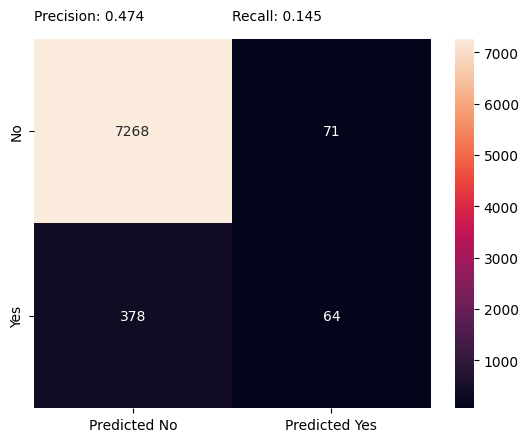

In [72]:
def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], show_precision_recall=True):

  cm = confusion_matrix(y_true, y_pred) # tn, fp, fn, tp

  df_cm = pd.DataFrame(cm, index = labels,
                    columns = ["Predicted "+labels[0],"Predicted "+labels[1]])
  sns.heatmap(df_cm, annot=True, fmt='g')

  if show_precision_recall:
    # Which percentage of positive classifications were actually positive?
    plt.text(0, -0.1, f"Precision: {(cm[1][1]/(cm[1][1]+cm[0][1])):.3f}")
    # Which percentage of positive observations have been classified as positive?
    plt.text(1, -0.1, f"Recall: {(cm[1][1]/(cm[1][1]+cm[1][0])):.3f}")


plot_confusion_matrix(y_train_transformed, y_pred_train, ["No", "Yes"])

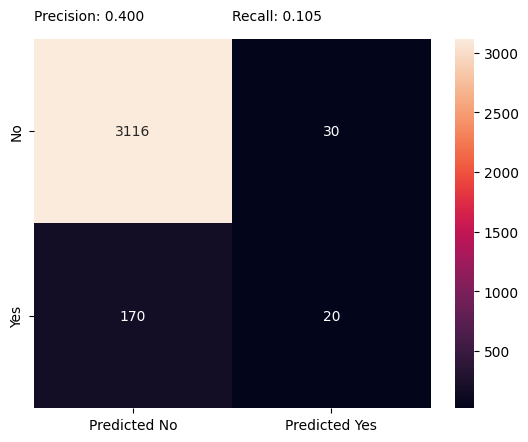

In [73]:
plot_confusion_matrix(y_test_transformed, y_pred_test, ["No", "Yes"])

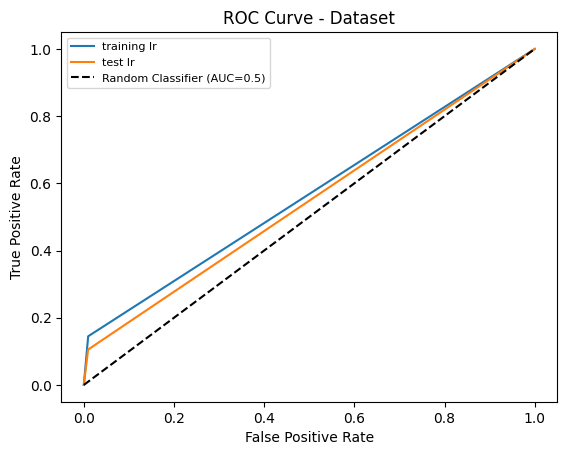

In [74]:
fpr, tpr, _ = roc_curve(y_train_transformed, y_pred_train)
plt.plot(fpr, tpr, label='training lr')
fpr, tpr, _ = roc_curve(y_test_transformed, y_pred_test)
plt.plot(fpr, tpr, label='test lr')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC=0.5)")
plt.title('ROC Curve - Dataset')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.legend(fontsize=8)

Although the overall accuracy is high (94%), this is primarily due to the model correctly predicting the majority class. The macro-average F1-score (0.60 on train and 0.57 on test) indicates that when treating both classes equally, the performance is much lower.
This suggests that the logistic regression model, as it stands, is not effective at capturing the positive (rare) cases

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve

lr = LogisticRegression()
lr.fit(X_train_transformed, y_train_transformed)

y_pred_train_db_diff = lr.predict(X_train_transformed)
y_pred_train_db_diff = np.where(y_proba_train[:,1]>0.25,1,0)
y_proba_train_db_diff = lr.predict_proba(X_train_transformed)
y_pred_test_db_diff = lr.predict(X_test_transformed)
y_pred_test_db_diff = np.where(y_proba_test[:,1]>0.25,1,0)
y_proba_test_db_diff =  lr.predict_proba(X_test_transformed)

print("TRAIN REPORT")
print(classification_report(y_train_transformed, y_pred_train_db_diff))
print("TEST REPORT")
print(classification_report(y_test_transformed, y_pred_test_db_diff))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      7339
           1       0.43      0.45      0.44       442

    accuracy                           0.94      7781
   macro avg       0.70      0.71      0.70      7781
weighted avg       0.94      0.94      0.94      7781

TEST REPORT
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3146
           1       0.41      0.45      0.43       190

    accuracy                           0.93      3336
   macro avg       0.69      0.71      0.70      3336
weighted avg       0.93      0.93      0.93      3336



By adjusting the threshold from the default 0.5 to 0.25, the model's sensitivity for detecting positive cases has improved, as reflected by the increased recall (around 45%) for TARGET = 1. Although this comes with a slight drop in precision for the minority class, overall the model achieves a more balanced performance

In [76]:
lr_bal = LogisticRegression(class_weight='balanced')
lr_bal.fit(X_train_transformed, y_train_transformed)

y_pred_train_lr_balanced = lr_bal.predict(X_train_transformed)
y_proba_train_lr_balanced = lr_bal.predict_proba(X_train_transformed)
y_pred_test_lr_balanced = lr_bal.predict(X_test_transformed)
y_proba_test_lr_balanced =  lr_bal.predict_proba(X_test_transformed)

print("TRAIN REPORT")
print(classification_report(y_train_transformed, y_pred_train_lr_balanced))
print("TEST REPORT")
print(classification_report(y_test_transformed, y_pred_test_lr_balanced))

TRAIN REPORT
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      7339
           1       0.27      0.93      0.42       442

    accuracy                           0.85      7781
   macro avg       0.63      0.89      0.67      7781
weighted avg       0.95      0.85      0.89      7781

TEST REPORT
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      3146
           1       0.26      0.90      0.40       190

    accuracy                           0.85      3336
   macro avg       0.63      0.87      0.66      3336
weighted avg       0.95      0.85      0.88      3336



By using balanced class weights, the logistic regression model becomes much more sensitive to the minority class, achieving around 90% recall for positives, while sacrificing precision and overall accuracy. This model configuration can be valuable when the cost of missing positive cases is high, even though it results in a greater number of false positives- In our analysis it is better to increase precision for 1, because the bank loses money if number of false positives is large.

So I would say that for our study, the best for now is Logistic Regression with change of classification decision boundary.

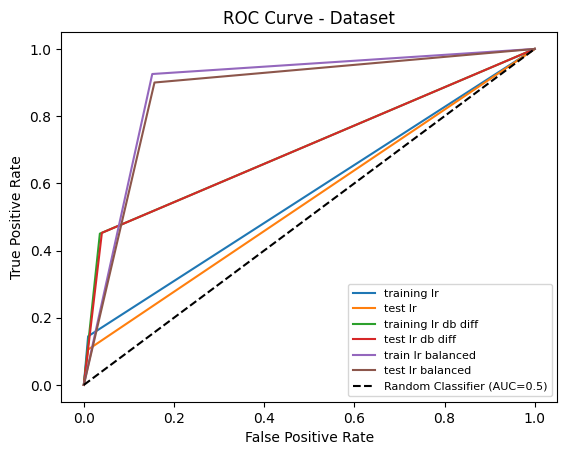

In [77]:
Sfpr, tpr, _ = roc_curve(y_train_transformed, y_pred_train)
plt.plot(fpr, tpr, label='training lr')
fpr, tpr, _ = roc_curve(y_test_transformed, y_pred_test)
plt.plot(fpr, tpr, label='test lr')
fpr, tpr, _ = roc_curve(y_train_transformed, y_pred_train_db_diff)
plt.plot(fpr, tpr, label='training lr db diff')
fpr, tpr, _ = roc_curve(y_test_transformed, y_pred_test_db_diff)
plt.plot(fpr, tpr, label='test lr db diff')
fpr, tpr, _ = roc_curve(y_train_transformed, y_pred_train_lr_balanced)
plt.plot(fpr, tpr, label='train lr balanced')
fpr, tpr, _ = roc_curve(y_test_transformed, y_pred_test_lr_balanced)
plt.plot(fpr, tpr, label='test lr balanced')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC=0.5)")
plt.title('ROC Curve - Dataset')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.legend(fontsize=8)

In [78]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.metrics import log_loss
from sklearn.utils import shuffle

def fit(model, X_train, y_train, X_test, y_test, batch_size=1, epochs=100, verbose=True):

  n_batches = int(X_train.shape[0]//batch_size)+1

  classes = np.unique(y)

  batch_losses = []

  for epoch in range(epochs):
          X_shuffled, Y_shuffled = shuffle(X_train, y_train)
          for batch in range(n_batches):
              batch_start = int(batch*batch_size)
              batch_end = int((batch+1)*batch_size)
              X_batch = X_shuffled[batch_start:batch_end,:]
              Y_batch = Y_shuffled[batch_start:batch_end]
              model.partial_fit(X_batch, Y_batch, classes=classes)
              loss = log_loss(y_test, model.predict_proba(X_test),labels=classes)
              batch_losses.append(loss)

          if verbose:
            print("Loss all'epoca %d = %.4f" % (epoch+1, loss))

  return model

def evaluate(model, X, y, label=None):
  y_pred = model.predict(X)
  y_proba = model.predict_proba(X)

  if label is not None:
    print(label)

  accuracy = accuracy_score(y, y_pred)
  loss = log_loss(y, y_proba)
  print(f"Accuracy={accuracy} Log Loss={loss:.3f})")
  return accuracy, loss

In [79]:
batchs_sizes = [2048, 1024, 512, 256, 128, 64, 32, 16]

best_model = None
best_loss = 1

for batch_size  in batchs_sizes:
  print(f"BATCH SIZE = {batch_size}")
  sgd = SGDClassifier(loss="log_loss")
  sgd = fit(sgd, X_train_transformed, y_train_transformed, X_test_transformed, y_test_transformed, batch_size=batch_size, epochs=200, verbose=False)
  evaluate(sgd, X_train_transformed, y_train_transformed, label="TRAIN SET")
  accuracy, loss = evaluate(sgd, X_test_transformed, y_test_transformed, label="TEST SET")

  if best_model is None or loss<best_loss:
    best_model = sgd
    best_loss = loss

BATCH SIZE = 2048
TRAIN SET
Accuracy=0.9429379257164889 Log Loss=0.138)
TEST SET
Accuracy=0.940347721822542 Log Loss=0.146)
BATCH SIZE = 1024
TRAIN SET
Accuracy=0.9399820074540548 Log Loss=0.140)
TEST SET
Accuracy=0.9370503597122302 Log Loss=0.147)
BATCH SIZE = 512
TRAIN SET
Accuracy=0.9413957074926103 Log Loss=0.139)
TEST SET
Accuracy=0.9391486810551559 Log Loss=0.146)
BATCH SIZE = 256
TRAIN SET
Accuracy=0.9426808893458425 Log Loss=0.139)
TEST SET
Accuracy=0.939748201438849 Log Loss=0.146)
BATCH SIZE = 128
TRAIN SET
Accuracy=0.9428094075311657 Log Loss=0.140)
TEST SET
Accuracy=0.9400479616306955 Log Loss=0.147)
BATCH SIZE = 64
TRAIN SET
Accuracy=0.9428094075311657 Log Loss=0.139)
TEST SET
Accuracy=0.9406474820143885 Log Loss=0.147)
BATCH SIZE = 32
TRAIN SET
Accuracy=0.942423852975196 Log Loss=0.138)
TEST SET
Accuracy=0.939748201438849 Log Loss=0.146)
BATCH SIZE = 16
TRAIN SET
Accuracy=0.9420382984192264 Log Loss=0.138)
TEST SET
Accuracy=0.9391486810551559 Log Loss=0.146)


In [80]:
print(classification_report(y_train_transformed, best_model.predict(X_train_transformed)))
print(classification_report(y_test_transformed, best_model.predict(X_test_transformed)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7339
           1       0.48      0.15      0.23       442

    accuracy                           0.94      7781
   macro avg       0.71      0.57      0.60      7781
weighted avg       0.92      0.94      0.93      7781

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3146
           1       0.40      0.11      0.17       190

    accuracy                           0.94      3336
   macro avg       0.67      0.55      0.57      3336
weighted avg       0.92      0.94      0.92      3336



Optimizing batch size doesn't drastically affect performance. The precision for the minority class (class 1) is around 0.40–0.48, while recall is low at 0.11–0.15. This indicates that the classifier is identifying more true positives, but still misses a large number of them

In [81]:
from sklearn.utils.class_weight import compute_class_weight
batchs_sizes = [2048, 1024, 512, 256, 128, 64, 32, 16]

best_model = None
best_loss = 1

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_transformed), y=y_train_transformed)
class_weight_dict = dict(zip(np.unique(y_train_transformed), class_weights))

for batch_size  in batchs_sizes:
  print(f"BATCH SIZE = {batch_size}")
  sgd = SGDClassifier(loss="log_loss", class_weight=class_weight_dict)
  sgd = fit(sgd, X_train_transformed, y_train_transformed, X_test_transformed, y_test_transformed, batch_size=batch_size, epochs=200, verbose=False)
  evaluate(sgd, X_train_transformed, y_train_transformed, label="TRAIN SET")
  accuracy, loss = evaluate(sgd, X_test_transformed, y_test_transformed, label="TEST SET")

  if best_model is None or loss<best_loss:
    best_model = sgd
    best_loss = loss

BATCH SIZE = 2048
TRAIN SET
Accuracy=0.8898599151779977 Log Loss=0.278)
TEST SET
Accuracy=0.8842925659472423 Log Loss=0.287)
BATCH SIZE = 1024
TRAIN SET
Accuracy=0.8510474232103843 Log Loss=0.367)
TEST SET
Accuracy=0.8456235011990407 Log Loss=0.377)
BATCH SIZE = 512
TRAIN SET
Accuracy=0.8407659683845264 Log Loss=0.390)
TEST SET
Accuracy=0.8372302158273381 Log Loss=0.400)
BATCH SIZE = 256
TRAIN SET
Accuracy=0.8479629867626269 Log Loss=0.380)
TEST SET
Accuracy=0.8408273381294964 Log Loss=0.391)
BATCH SIZE = 128
TRAIN SET
Accuracy=0.8722529237887161 Log Loss=0.318)
TEST SET
Accuracy=0.8663069544364509 Log Loss=0.328)
BATCH SIZE = 64
TRAIN SET
Accuracy=0.8497622413571521 Log Loss=0.371)
TEST SET
Accuracy=0.8453237410071942 Log Loss=0.381)
BATCH SIZE = 32
TRAIN SET
Accuracy=0.8664696054491711 Log Loss=0.328)
TEST SET
Accuracy=0.8603117505995204 Log Loss=0.336)
BATCH SIZE = 16
TRAIN SET
Accuracy=0.8468063230947179 Log Loss=0.373)
TEST SET
Accuracy=0.8438249400479616 Log Loss=0.381)


In [82]:
print(classification_report(y_train_transformed, best_model.predict(X_train_transformed)))
print(classification_report(y_test_transformed, best_model.predict(X_test_transformed)))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      7339
           1       0.32      0.81      0.46       442

    accuracy                           0.89      7781
   macro avg       0.65      0.85      0.70      7781
weighted avg       0.95      0.89      0.91      7781

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      3146
           1       0.30      0.80      0.44       190

    accuracy                           0.88      3336
   macro avg       0.65      0.84      0.69      3336
weighted avg       0.95      0.88      0.91      3336



Using balanced class weights with the SGD classifier has significantly improved the model’s recall for the minority class (TARGET = 1) from very low levels (around 15% recall in the unweighted model) to 85%. However, this improvement comes with a reduction in precision (down to about 30%) and a drop in overall accuracy (to around 88%)

In [83]:
from sklearn.svm import SVC

def classifier_report(model, data):
  X, y = data
  y_pred = model.predict(X)
  report = classification_report(y, y_pred)
  print(report)
  print(confusion_matrix(y, y_pred))

In [84]:
svc = SVC(kernel="linear")
svc.fit(X_train_transformed, y_train_transformed)
print(svc.score(X_test_transformed, y_test_transformed))
classifier_report(svc, (X_test_transformed, y_test_transformed))

0.9430455635491607
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3146
           1       0.00      0.00      0.00       190

    accuracy                           0.94      3336
   macro avg       0.47      0.50      0.49      3336
weighted avg       0.89      0.94      0.92      3336

[[3146    0]
 [ 190    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


With a linear kernel and without further adjustments, the SVC is not capturing the characteristics of the minority class (TARGET = 1) at all.

In [85]:
svc = SVC(kernel="linear", class_weight={1:30})
svc.fit(X_train_transformed, y_train_transformed)
print(svc.score(X_test_transformed, y_test_transformed))
classifier_report(svc, (X_test_transformed, y_test_transformed))

0.795863309352518
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      3146
           1       0.21      0.97      0.35       190

    accuracy                           0.80      3336
   macro avg       0.61      0.88      0.62      3336
weighted avg       0.95      0.80      0.85      3336

[[2470  676]
 [   5  185]]


By heavily weighting the positive class (TARGET = 1) with a factor of 30, the model dramatically increases its sensitivity to the positive class. This is evident from the high recall (97%) for class 1—almost all positive cases are now detected. The downside is that the model becomes overly aggressive in predicting the positive class. This results in a large number of false positives (636 instances), which is why the precision for the positive class drops to only 21%.

In [86]:
svc = SVC(kernel="rbf")
svc.fit(X_train_transformed, y_train_transformed)
print(svc.score(X_test_transformed, y_test_transformed))
classifier_report(svc, (X_test_transformed, y_test_transformed))

0.9430455635491607
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3146
           1       0.50      0.01      0.01       190

    accuracy                           0.94      3336
   macro avg       0.72      0.50      0.49      3336
weighted avg       0.92      0.94      0.92      3336

[[3145    1]
 [ 189    1]]


Despite an accuracy of 94%, the model fails to capture almost any of the minority (positive) class due to severe imbalance. The high accuracy is driven solely by the majority class. For class 1, the model achieves a precision of 0.50, meaning that when it does predict a positive, about half of those predictions are correct. However, the recall for class 1 is only 0.01, which indicates that the model is capturing almost none of the actual positive instances. In other words, even though half of its positive predictions are accurate, it is missing nearly 99% of the true positive cases. This extremely low recall is problematic because it means that the classifier fails to identify almost all of the minority class examples

In [87]:
svc = SVC(kernel="rbf", class_weight={1:30})
svc.fit(X_train_transformed, y_train_transformed)
print(svc.score(X_test_transformed, y_test_transformed))

classifier_report(svc, (X_test_transformed, y_test_transformed))

0.9148681055155875
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      3146
           1       0.39      0.88      0.54       190

    accuracy                           0.91      3336
   macro avg       0.69      0.90      0.75      3336
weighted avg       0.96      0.91      0.93      3336

[[2884  262]
 [  22  168]]


by adjusting the class weights, the model is now much better at identifying the positive class (high recall), but it still struggles with precision, leading to some false positives

In [88]:
svc = SVC(kernel="poly", class_weight={1:30})
svc.fit(X_train_transformed, y_train_transformed)
print(svc.score(X_test_transformed, y_test_transformed))

classifier_report(svc, (X_test_transformed, y_test_transformed))

0.9121702637889688
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      3146
           1       0.38      0.85      0.52       190

    accuracy                           0.91      3336
   macro avg       0.68      0.88      0.74      3336
weighted avg       0.96      0.91      0.93      3336

[[2882  264]
 [  29  161]]


In [89]:
svc = SVC(kernel="sigmoid", class_weight={1:30})
svc.fit(X_train_transformed, y_train_transformed)
print(svc.score(X_test_transformed, y_test_transformed))

classifier_report(svc, (X_test_transformed, y_test_transformed))

0.8144484412470024
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      3146
           1       0.22      0.87      0.35       190

    accuracy                           0.81      3336
   macro avg       0.60      0.84      0.62      3336
weighted avg       0.95      0.81      0.86      3336

[[2552  594]
 [  25  165]]


In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

In [91]:
tree = DecisionTreeClassifier()
tree.fit(X_train_transformed, y_train_transformed)
tree.score(X_test_transformed, y_test_transformed)

0.9658273381294964

In [93]:
classifier_report(tree, (X_test_transformed, y_test_transformed))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3146
           1       0.69      0.73      0.71       190

    accuracy                           0.97      3336
   macro avg       0.84      0.86      0.85      3336
weighted avg       0.97      0.97      0.97      3336

[[3083   63]
 [  51  139]]


The high overall accuracy and the weighted average metrics (0.97 for precision, recall, and F1-score) indicate that the classifier performs very well overall, particularly for the dominant class (negatives).

Performance on the Minority Class:
Although the performance for class 1 (positives) is not as high as for class 0, a precision of 0.69 and a recall of 0.73 are quite respectable given the challenges often encountered with imbalanced datasets. This means the model is relatively effective at capturing the positive cases, with a moderate trade-off between false positives and false negatives.

In [94]:
tree = DecisionTreeClassifier(max_depth=100, min_samples_leaf=10)
tree.fit(X_train_transformed, y_train_transformed)
tree.score(X_test_transformed, y_test_transformed)

0.967326139088729

In [95]:
classifier_report(tree, (X_train_transformed, y_train_transformed))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7339
           1       0.81      0.89      0.85       442

    accuracy                           0.98      7781
   macro avg       0.90      0.94      0.92      7781
weighted avg       0.98      0.98      0.98      7781

[[7247   92]
 [  47  395]]


In [96]:
classifier_report(tree, (X_test_transformed, y_test_transformed))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3146
           1       0.69      0.78      0.73       190

    accuracy                           0.97      3336
   macro avg       0.84      0.88      0.86      3336
weighted avg       0.97      0.97      0.97      3336

[[3079   67]
 [  42  148]]


By setting a maximum depth of 100 and a minimum of 10 samples per leaf, the Decision Tree has been constrained to avoid overfitting and to generalize better. The recall for class 1 improved to 78%, meaning the model is capturing a larger proportion of the actual positive cases compared to a less-tuned version. The use of max_depth=100 and min_samples_leaf=10 appears to help the tree generalize better, achieving a high overall accuracy without overfitting, while also slightly boosting the ability to detect positives.

A graphic tree can help to understand why, given specific features, the model predict a certain output

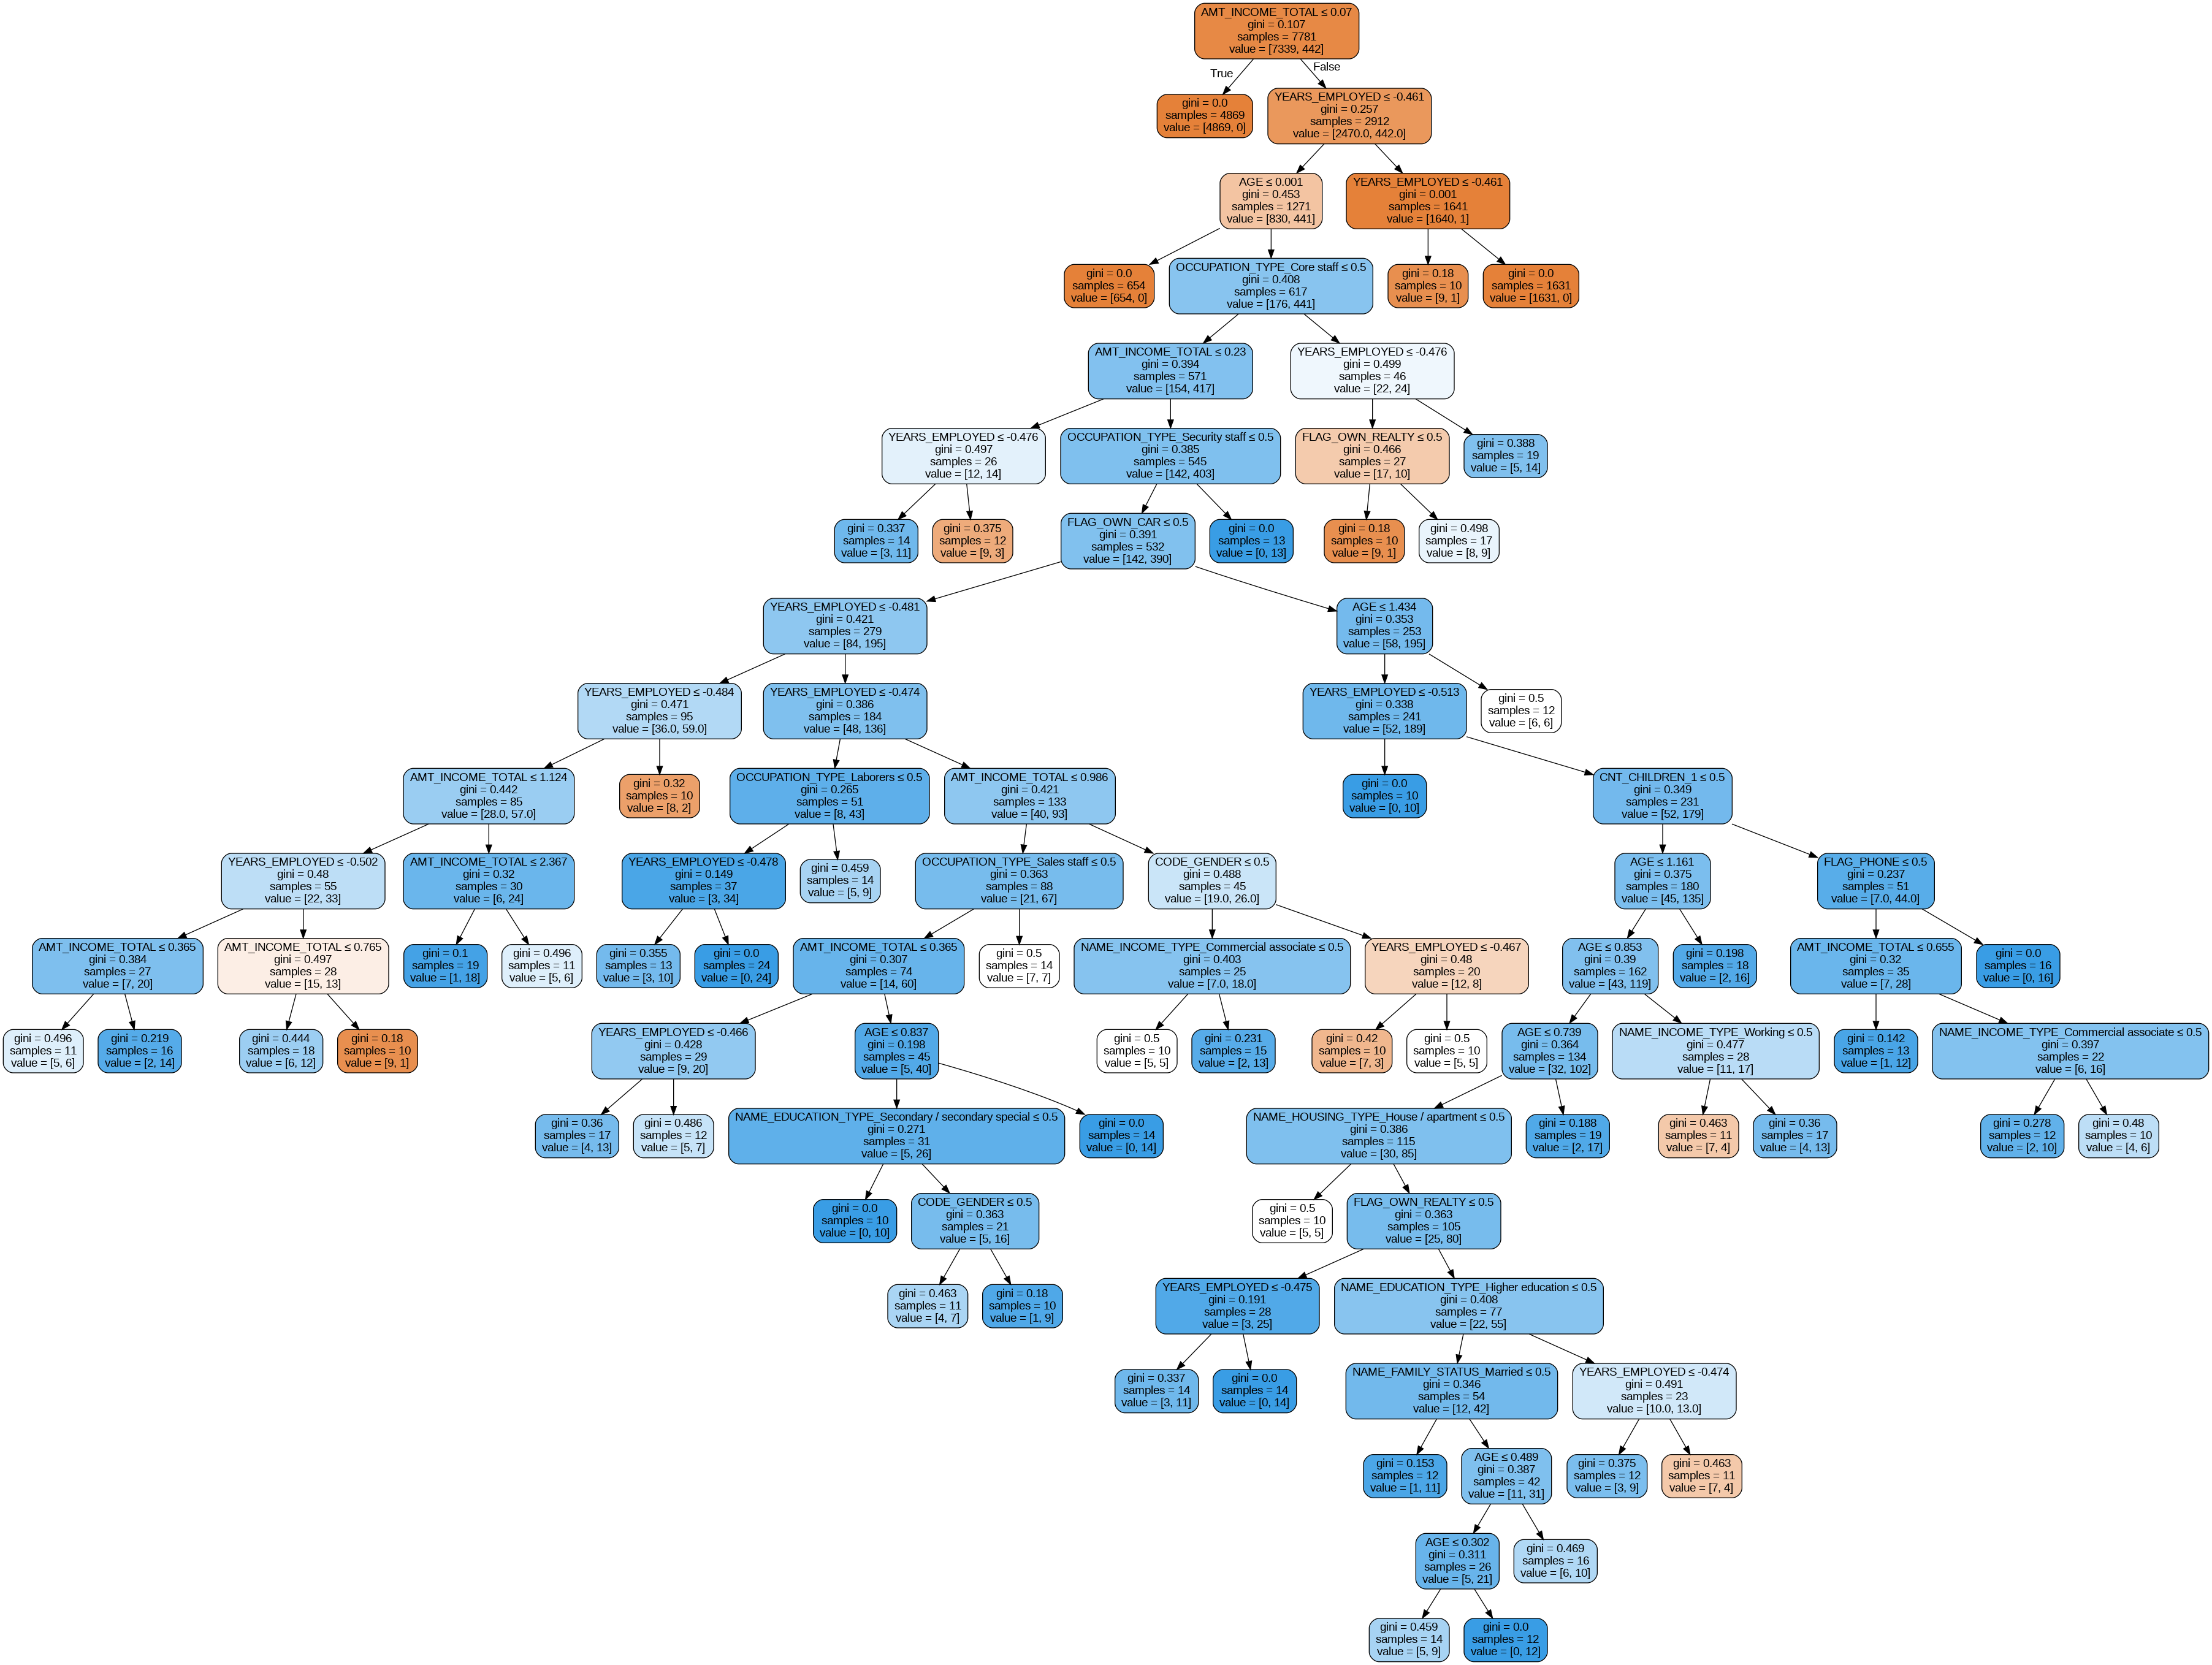

In [99]:
from IPython.display import Image, display
import graphviz

def tree_viz(tree, feature_names=None, class_names=None):
  dot_data = export_graphviz(tree, out_file=None,
                        feature_names=feature_names,
                        class_names=class_names,
                        filled=True, rounded=True,
                        special_characters=True)
  graph = graphviz.Source(dot_data, filename="tree", format="png")
  graph.view()
  display(Image("tree.png"))

tree_viz(tree, feature_names=X_train_transformed_df.columns.values)

                                  Feature  Importance
1                                     AGE    0.508830
2                          YEARS_EMPLOYED    0.296341
0                        AMT_INCOME_TOTAL    0.152403
27             OCCUPATION_TYPE_Core staff    0.005681
51                        FLAG_OWN_REALTY    0.005571
49                            CODE_GENDER    0.004608
40            OCCUPATION_TYPE_Sales staff    0.003489
3   NAME_INCOME_TYPE_Commercial associate    0.003386
7                NAME_INCOME_TYPE_Working    0.003296
42         OCCUPATION_TYPE_Security staff    0.002774


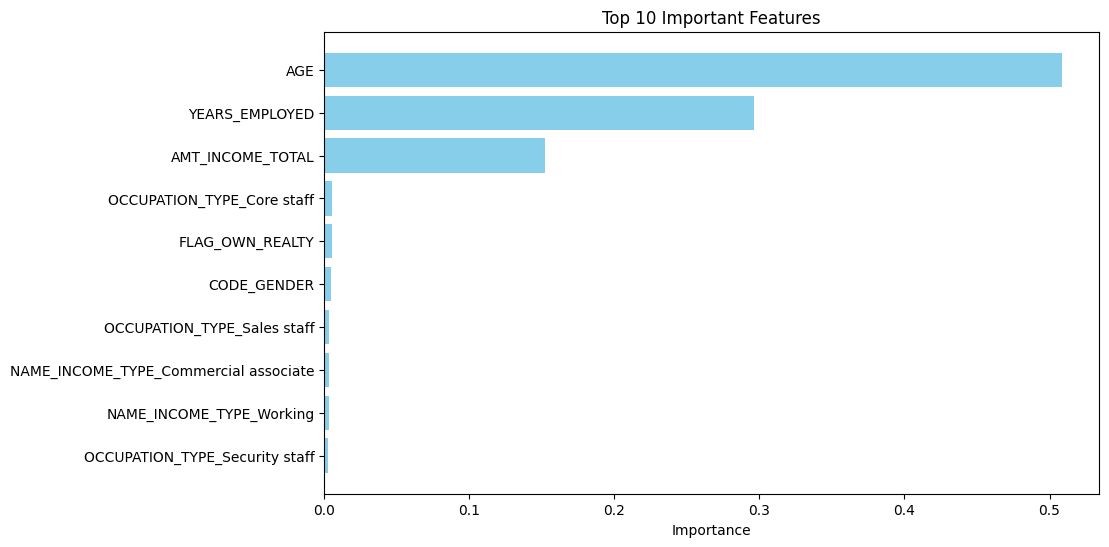

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

# Get features importance
feature_importance = tree.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train_transformed_df.columns,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df.head(10))


plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()
plt.show()

The feature importance output shows that the decision tree primarily relies on three features to make its predictions:

AGE (≈50.9% importance):
Age is by far the most influential feature in this model. It alone contributes over half of the predictive power, indicating that a customer's age is a critical determinant in the target decision.

YEARS_EMPLOYED (≈29.6% importance):
The number of years employed is the second most important feature, suggesting that employment duration plays a key role in distinguishing between the target classes.

AMT_INCOME_TOTAL (≈15.2% importance):
Income is also significant, though its influence is much less than age and years employed. Still, it accounts for a substantial portion of the decision-making process.

The remaining features have much lower importance (each below 1%), which implies that while they may contribute to some fine adjustments in the decision process, the model’s predictions are largely driven by age, employment duration, and income

In [101]:
for n_tree in [1, 2, 3, 5, 10, 20, 50, 100, 500, 1000]:
  print(f"Addestramento di una foresta con {n_tree} alberi...")
  forest = RandomForestClassifier(n_tree, max_depth=10, min_samples_leaf=5)
  forest.fit(X_train_transformed, y_train_transformed)
  print(f"Accuracy: Train={forest.score(X_train_transformed, y_train_transformed):.3f} Test={forest.score(X_test_transformed, y_test_transformed):.3f}")

Addestramento di una foresta con 1 alberi...
Accuracy: Train=0.971 Test=0.962
Addestramento di una foresta con 2 alberi...
Accuracy: Train=0.960 Test=0.950
Addestramento di una foresta con 3 alberi...
Accuracy: Train=0.957 Test=0.948
Addestramento di una foresta con 5 alberi...
Accuracy: Train=0.975 Test=0.965
Addestramento di una foresta con 10 alberi...
Accuracy: Train=0.949 Test=0.945
Addestramento di una foresta con 20 alberi...
Accuracy: Train=0.964 Test=0.947
Addestramento di una foresta con 50 alberi...
Accuracy: Train=0.959 Test=0.951
Addestramento di una foresta con 100 alberi...
Accuracy: Train=0.967 Test=0.952
Addestramento di una foresta con 500 alberi...
Accuracy: Train=0.955 Test=0.946
Addestramento di una foresta con 1000 alberi...
Accuracy: Train=0.963 Test=0.950


In [102]:
forest = RandomForestClassifier(500, max_depth=100, min_samples_leaf=5)
forest.fit(X_train_transformed, y_train_transformed)

RandomForestClassifier(max_depth=100, min_samples_leaf=5, n_estimators=500)

In [103]:
classifier_report(forest, (X_test_transformed, y_test_transformed))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3146
           1       0.66      0.55      0.60       190

    accuracy                           0.96      3336
   macro avg       0.82      0.77      0.79      3336
weighted avg       0.96      0.96      0.96      3336

[[3093   53]
 [  86  104]]


The slight underperformance of the RandomForestClassifier compared to the single DecisionTreeClassifier in this case can be explained by a few factors:

- While a single decision tree may capture more specific patterns (i.e., lower bias but higher variance), random forests aim to reduce variance by combining multiple trees. The downside is that, in some cases, individual trees in the forest may not capture nuanced patterns as well as a fully grown, deep single tree.

- Random forests work by averaging the predictions of multiple decision trees. While this often leads to better generalization and robustness, it may sometimes lose some of the fine details captured by a single tree, especially if the single tree is slightly overfitted. In our case, the decision tree may have captured more specific information about minority class 1, whereas the random forest's ensemble approach smoothed out that specificity.

-  A single decision tree can focus on the most important features and build a more direct decision boundary. In contrast, random forests' feature selection (through random feature subsets) can spread importance across many features, which may reduce performance for specific classes.

In summary, while the random forest approach typically provides better generalization in many cases, the single decision tree may be overfitting slightly to the training data, capturing class-specific details that the random forest, with its bias-variance balancing, is less focused on

To conclude the decision tree classifier with max_depth=100 and min_samples_leaf=10 appears to be the most effective model predictor for our study because it shows the best statistics for the test set.
In any case, also random forest models show good results. Moreover, these models give us the possibility to understand why certain client features lead to TARGET=0 or TARGET=1